In [ ]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import xgboost
import lightgbm
import category_encoders
import missingno
import boruta
import tsfresh
import sktime
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import shap
import re
from sklearn.linear_model import LinearRegression
import matplotlib.colors as mcolors


In [2]:
data = pd.read_csv('final_data_modeling2.csv')


C:\Users\u840716\AppData\Local\Temp\3\ipykernel_12080\4193461837.py:1: DtypeWarning: Columns (21,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('final_data_modeling2.csv')


In [ ]:
# Drop duplicated columns from before
data = data.drop(columns=["First VT date (s)_x", "First MI date (s)_y", "Last Date (s)_y", "Last Date (s)_x", "First VT date (s)_y", "First MI date (s)_x"])

## Exploration

In [ ]:
# Load lab test data after first cleaning
df = pd.read_csv('final_data_modeling2.csv', parse_dates=['Date (s)'])
df['label'] = df['PatID'].str.startswith('VT').astype(int)
df['Uitslag_num'] = pd.to_numeric(df['Uitslag'], errors='coerce')


C:\Users\u840716\AppData\Local\Temp\3\ipykernel_12080\2187441604.py:2: DtypeWarning: Columns (21,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('final_data_modeling2.csv', parse_dates=['Date (s)'])


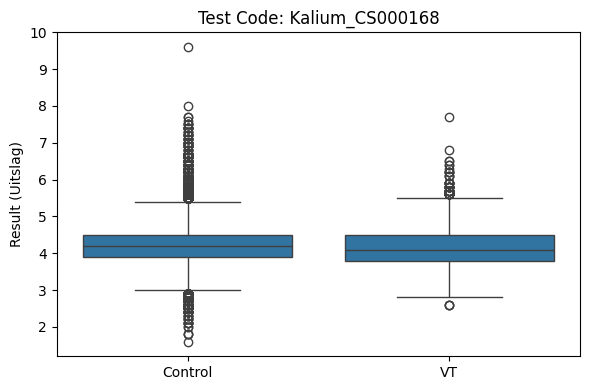

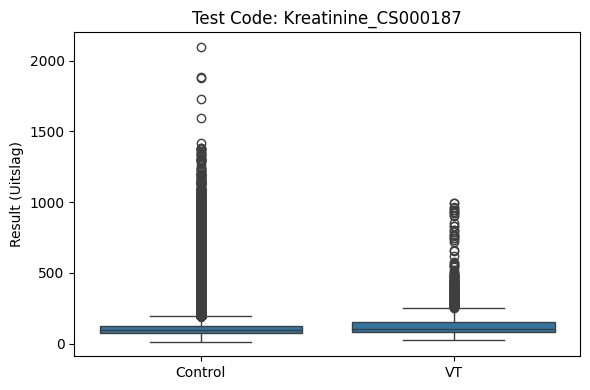

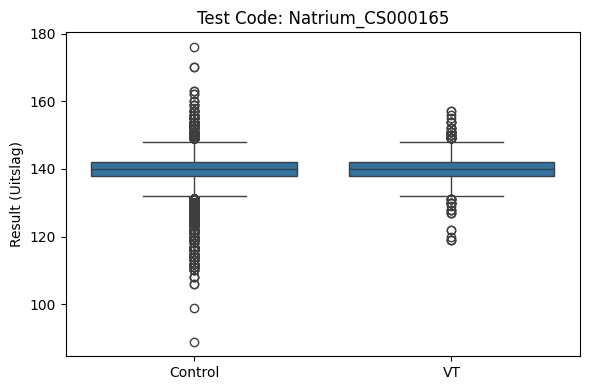

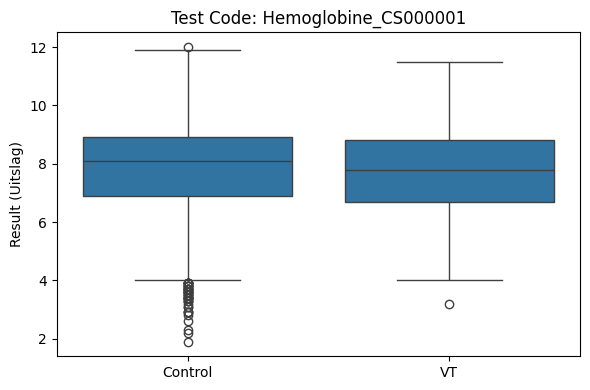

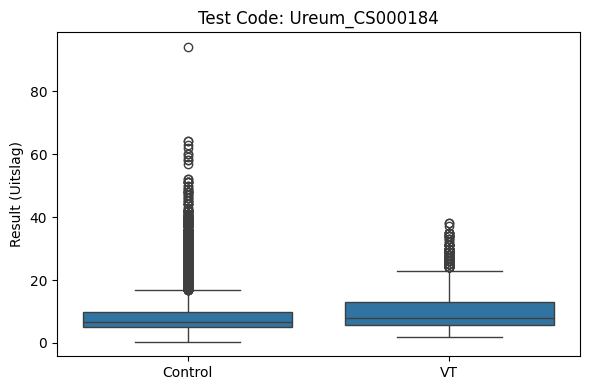

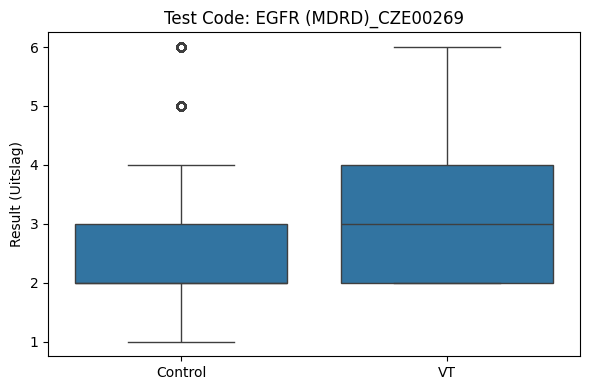

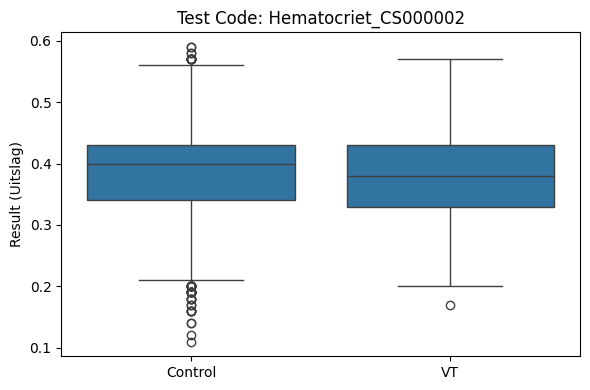

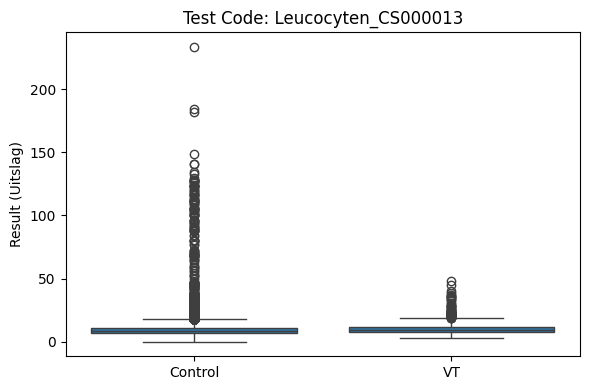

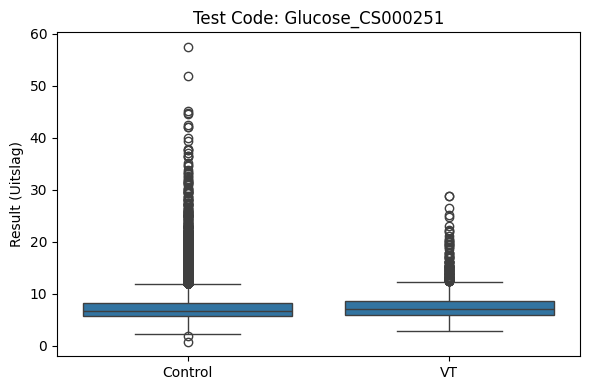

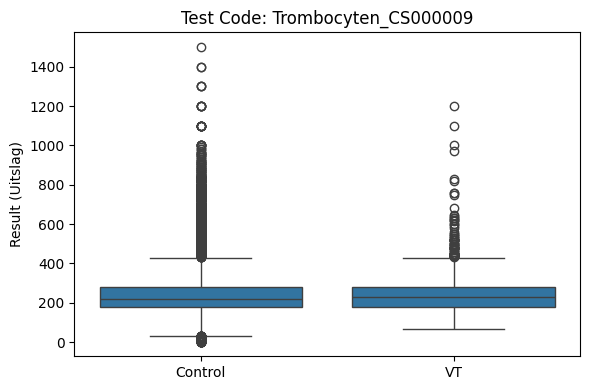

In [ ]:
# Top-10 frequent test codes, boxplots by VT vs. control
top10 = df['Oms_Code'].value_counts().head(10).index
for code in top10:
    subset = df[df['Oms_Code'] == code]
    plt.figure(figsize=(6,4))
    sns.boxplot(x='label', y='Uitslag_num', data=subset)
    plt.xticks([0,1], ['Control', 'VT'])
    plt.title(f'Test Code: {code}')
    plt.ylabel('Result (Uitslag)')
    plt.xlabel('')
    plt.tight_layout()
    plt.show()


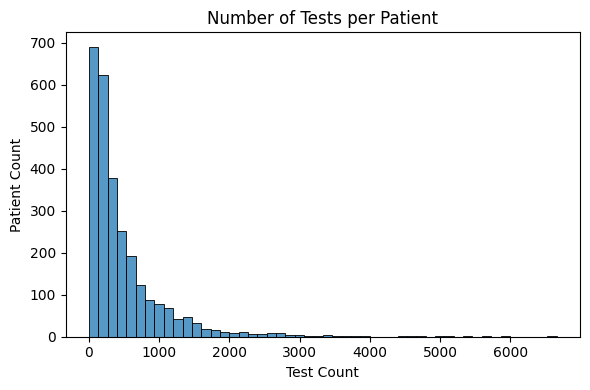

In [ ]:
# Tests per patient distribution
tests_per_patient = df.groupby('PatID').size().reset_index(name='count')
plt.figure(figsize=(6,4))
sns.histplot(tests_per_patient['count'], bins=50, kde=False)
plt.title('Number of Tests per Patient')
plt.xlabel('Test Count')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()


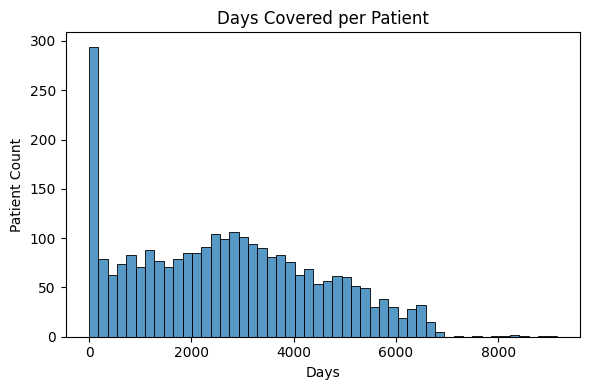

In [ ]:
# Time-span per patient
span = df.groupby('PatID')['Date (s)'].agg(first='min', last='max')
span['days_covered'] = (span['last'] - span['first']).dt.days
plt.figure(figsize=(6,4))
sns.histplot(span['days_covered'], bins=50, kde=False)
plt.title('Days Covered per Patient')
plt.xlabel('Days')
plt.ylabel('Patient Count')
plt.tight_layout()
plt.show()


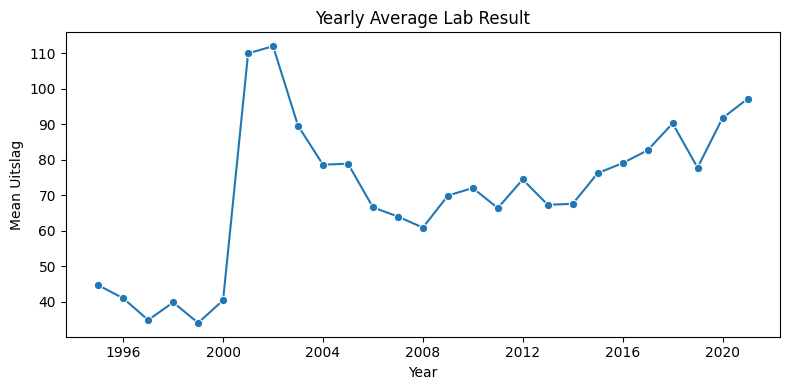

In [ ]:
# Monthly average lab result trend
df['Year'] = df['Date (s)'].dt.to_period('Y').dt.to_timestamp()
monthly_avg = df.groupby('Year')['Uitslag'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(x='Year', y='Uitslag', data=monthly_avg, marker='o')
plt.title('Yearly Average Lab Result')
plt.xlabel('Year')
plt.ylabel('Mean Uitslag')
plt.tight_layout()
plt.show()

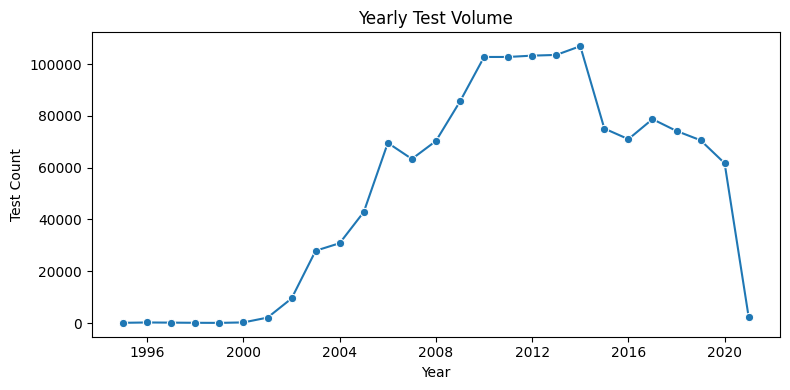

In [ ]:
# Monthly test volume
yearly_count = df.groupby('Year').size().reset_index(name='count')
plt.figure(figsize=(8,4))
sns.lineplot(x='Year', y='count', data=yearly_count, marker='o')
plt.title('Yearly Test Volume')
plt.xlabel('Year')
plt.ylabel('Test Count')
plt.tight_layout()
plt.show()

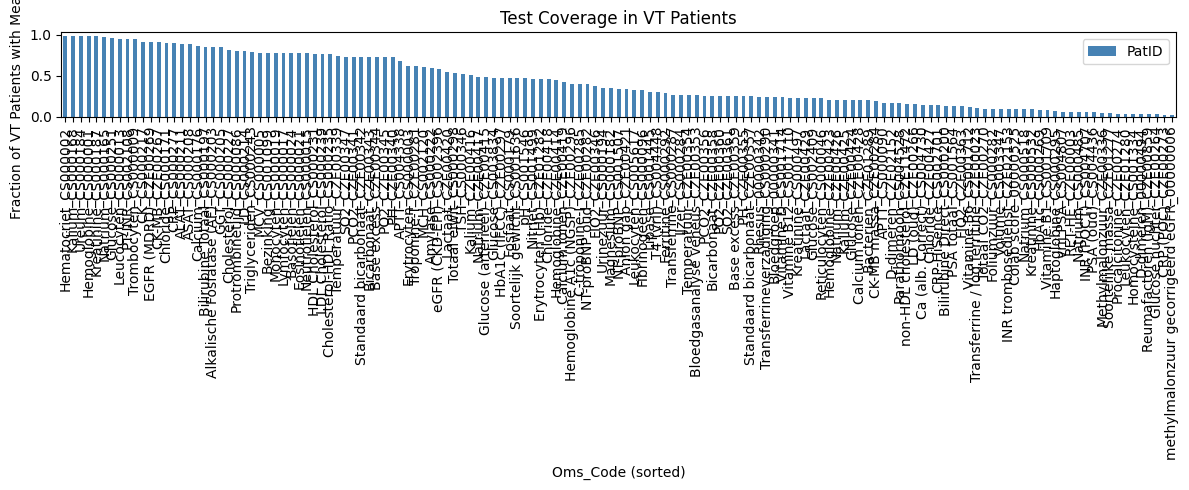

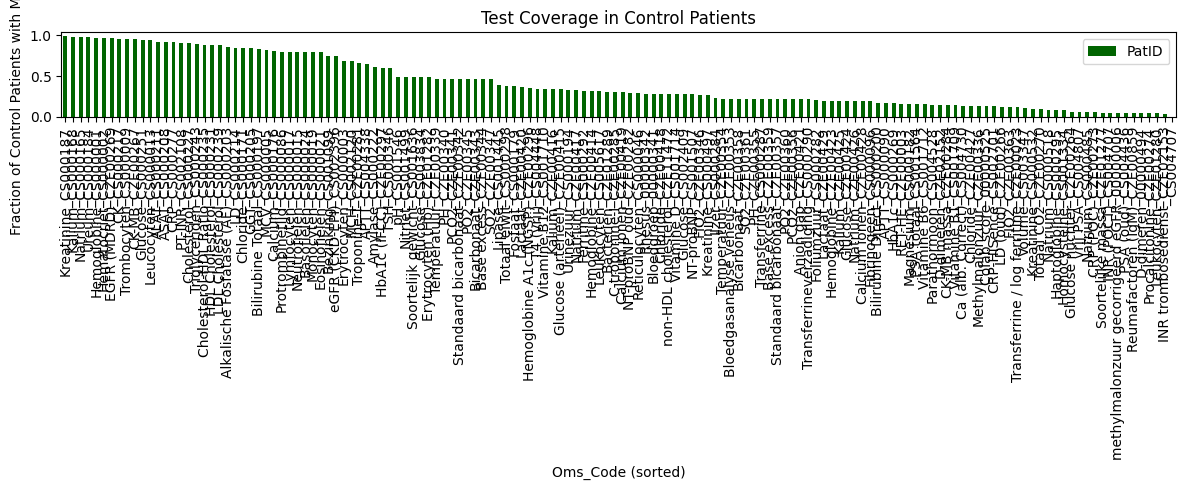

In [ ]:
# Split data into VT and Control groups
vt_data = df[df["label"] == 1]
control_data = df[df["label"] == 0]


vt_total = vt_data["PatID"].nunique()
control_total = control_data["PatID"].nunique()

# Calculate test coverage 
vt_coverage = vt_data.groupby("Oms_Code")["PatID"].nunique() / vt_total
control_coverage = control_data.groupby("Oms_Code")["PatID"].nunique() / control_total

# VT group plot
plt.figure(figsize=(12, 5))
vt_coverage.sort_values(ascending=False).plot(kind="bar", color="steelblue")
plt.title("Test Coverage in VT Patients")
plt.ylabel("Fraction of VT Patients with Measurement")
plt.xlabel("Oms_Code (sorted)")
plt.legend()
plt.tight_layout()
plt.show()

# Control group plot
plt.figure(figsize=(12, 5))
control_coverage.sort_values(ascending=False).plot(kind="bar", color="darkgreen")
plt.title("Test Coverage in Control Patients")
plt.ylabel("Fraction of Control Patients with Measurement")
plt.xlabel("Oms_Code (sorted)")
plt.legend()
plt.tight_layout()
plt.show()


## Cleaning steps pt 2

In [ ]:
# Count number of measurements per patient
patient_counts = data["PatID"].value_counts()

# Filter patients with fewer than 5 observations
patients_lt_5 = patient_counts[patient_counts < 5]

print(f"Number of patients with fewer than 5 observations: {len(patients_lt_5)}")


Number of patients with fewer than 5 observations: 22


In [ ]:
# Count number of measurements per patient
patient_counts = data["PatID"].value_counts()

# Filter patients with fewer than 2 observations
patients_lt_2 = patient_counts[patient_counts < 2]

print(f"Number of patients with fewer than 2 observations: {len(patients_lt_2)}")

Number of patients with fewer than 2 observations: 13


In [14]:
data = data[~data["PatID"].isin(patients_lt_2.index)]

In [15]:
patient_counts = data["PatID"].value_counts()
patient_counts

PatID
C122     6662
C1290    5995
C1176    5870
C2288    5686
C779     5423
         ... 
C1389       2
C736        2
C1143       2
C1710       2
C2582       2
Name: count, Length: 2732, dtype: int64

In [17]:
# Ensure date column is in datetime format
data["Date (s)"] = pd.to_datetime(data["Date (s)"])
data["Year"] = data["Date (s)"].dt.year

In [ ]:
# Total number of rows in lab_data
total_rows = data.shape[0]


# Count VT and Control patients
vt_count = data[data["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = data[data["PatID"].str.startswith("C")]["PatID"].nunique()
# Print results
print(f"Total rows in lab_data: {total_rows}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = data["Oms_Code"].nunique()


print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1355567
VT patients: 110
Control patients: 2622
Total unique tests (Oms_Code): 144


check availability of the lab measurements with the time features 

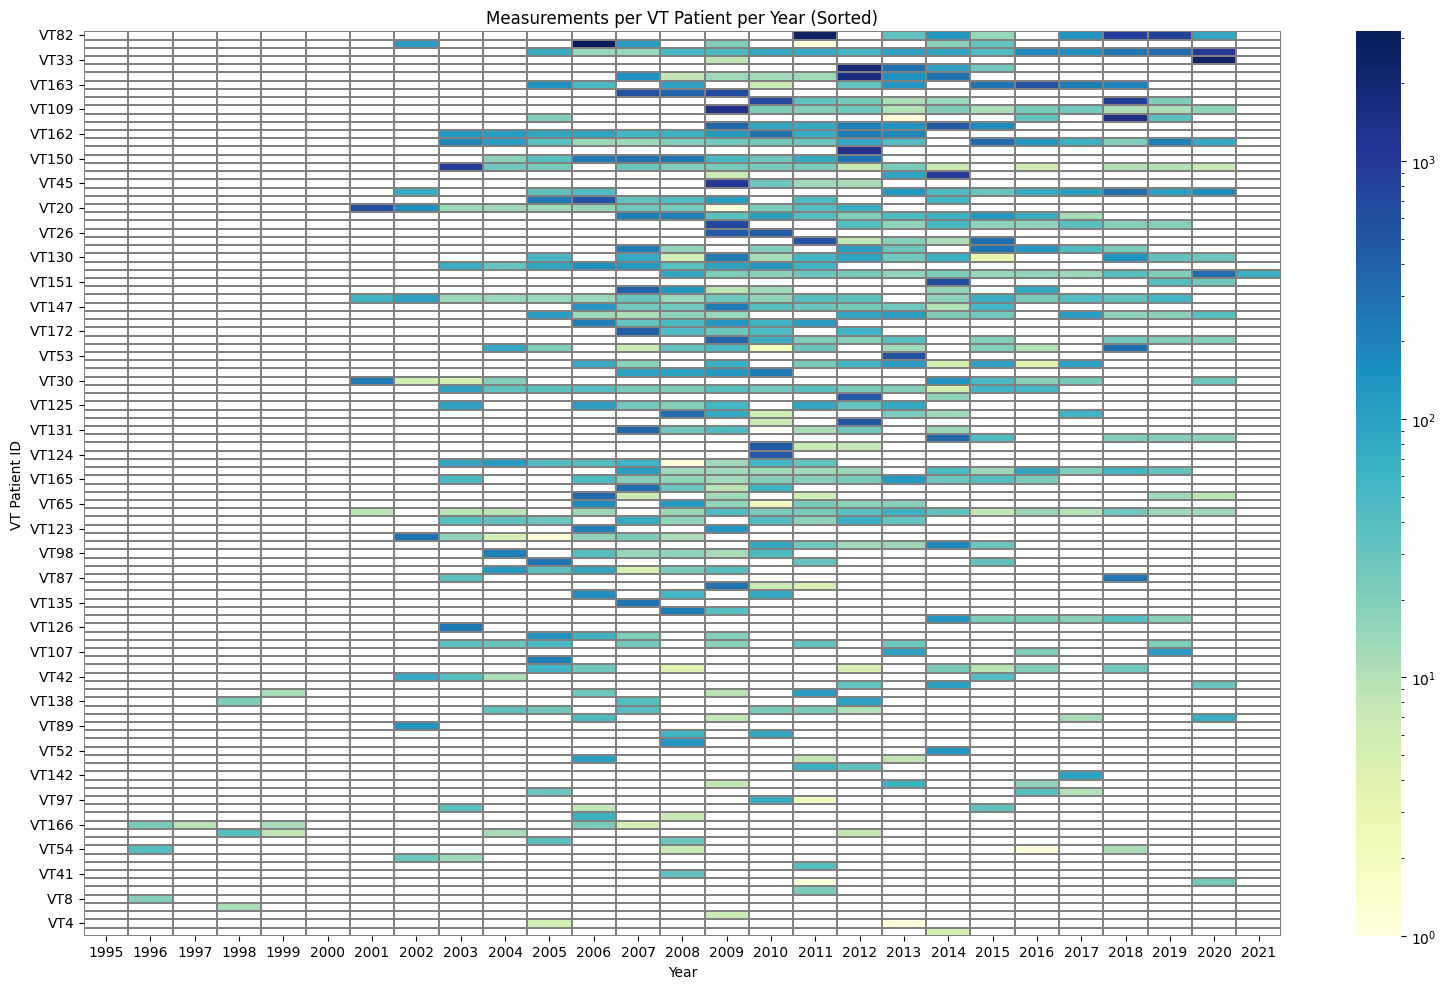

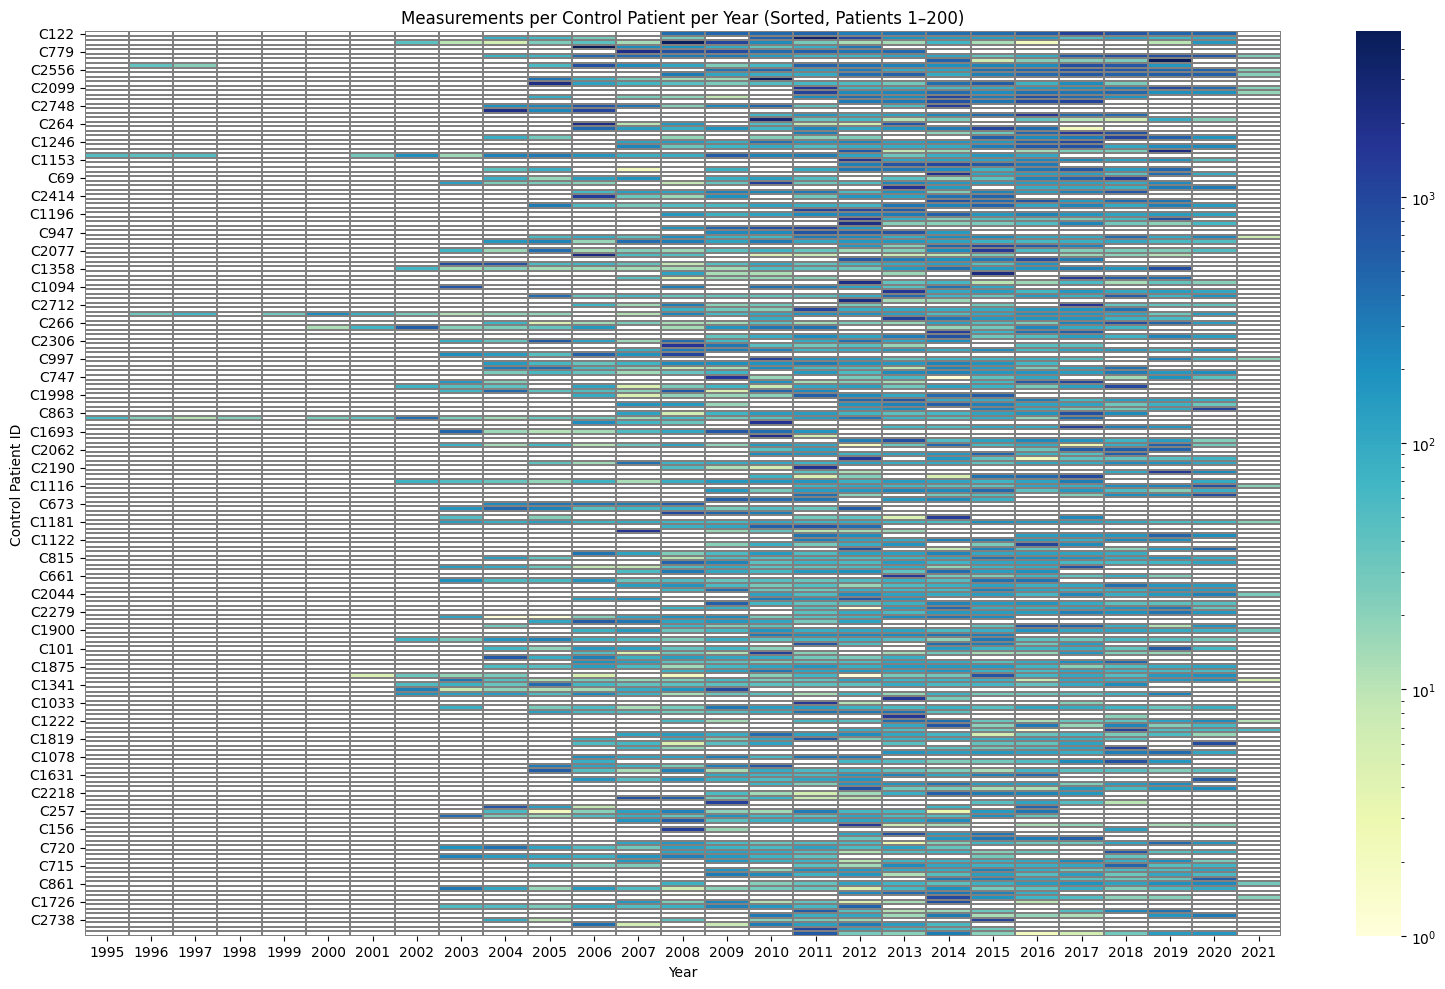

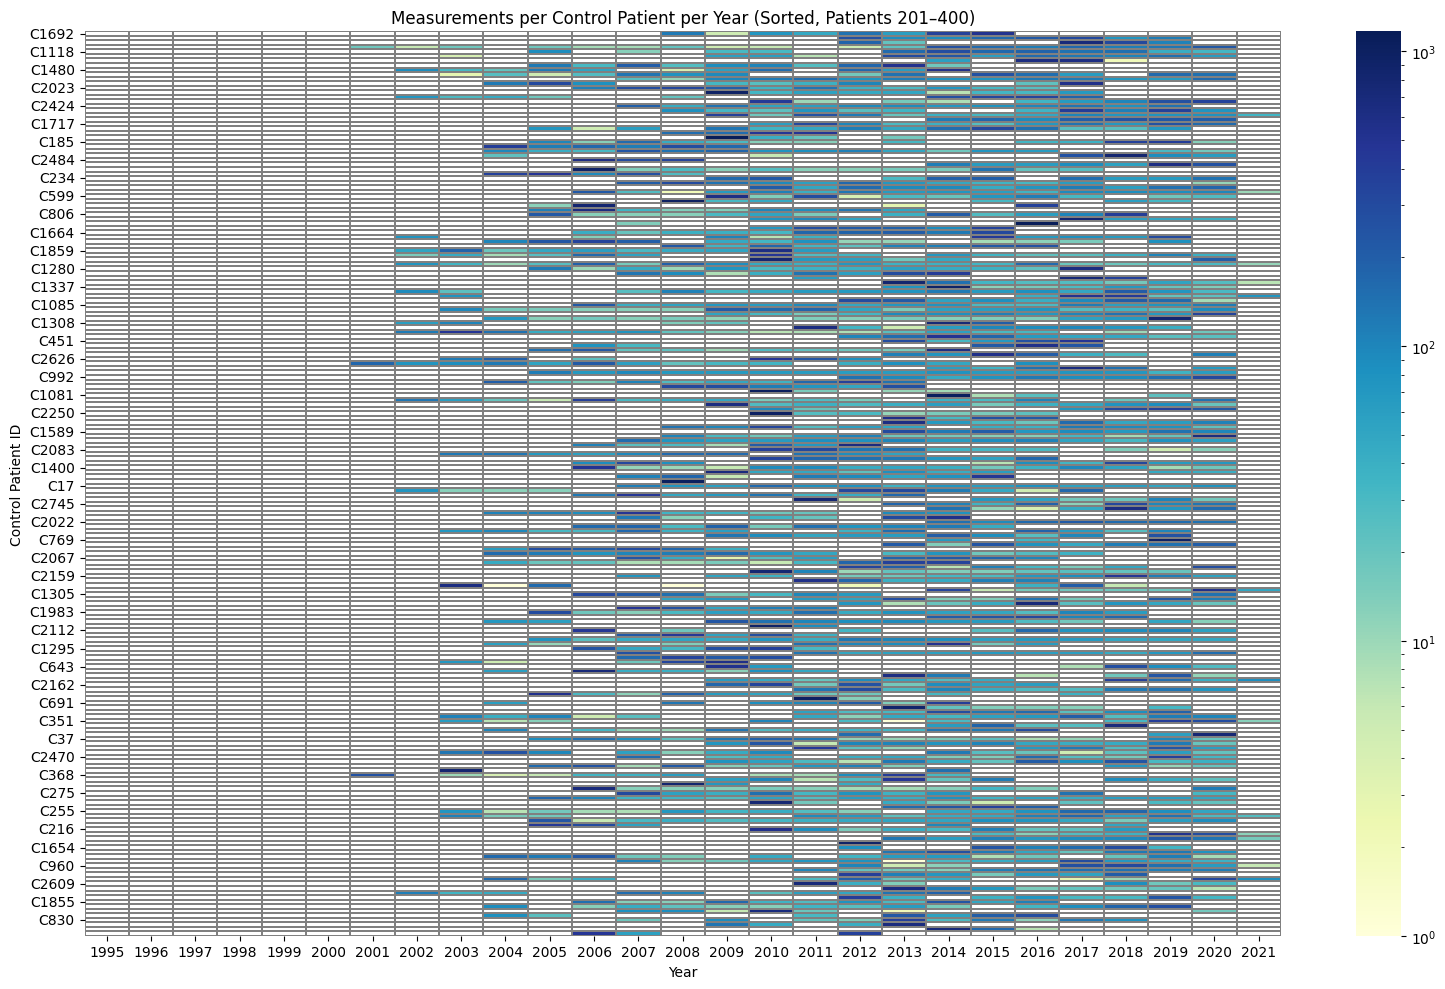

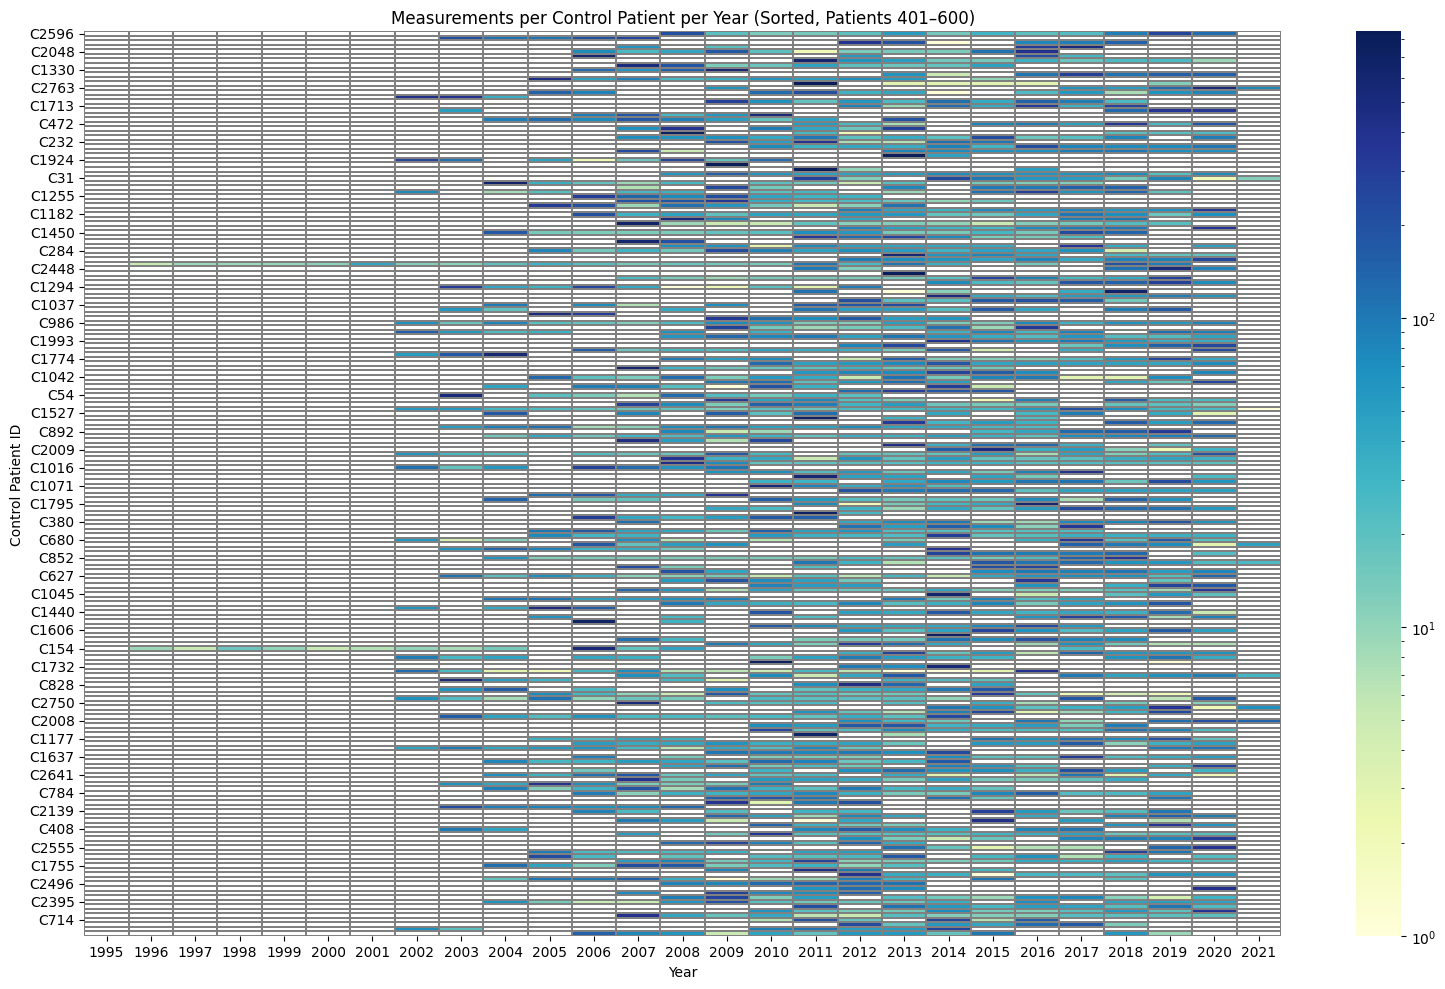

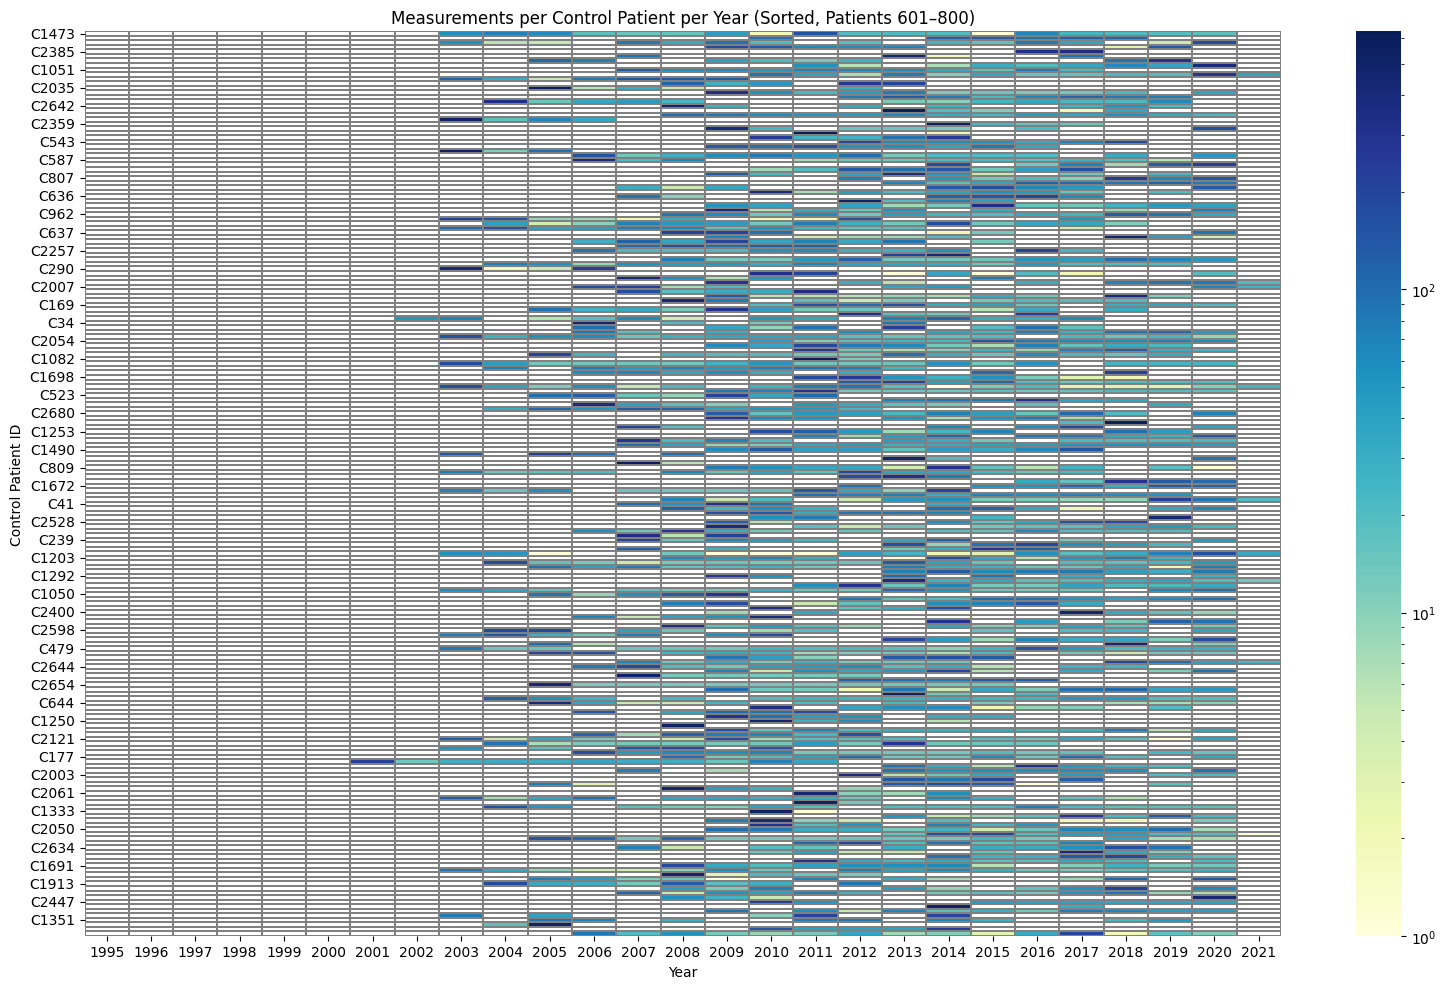

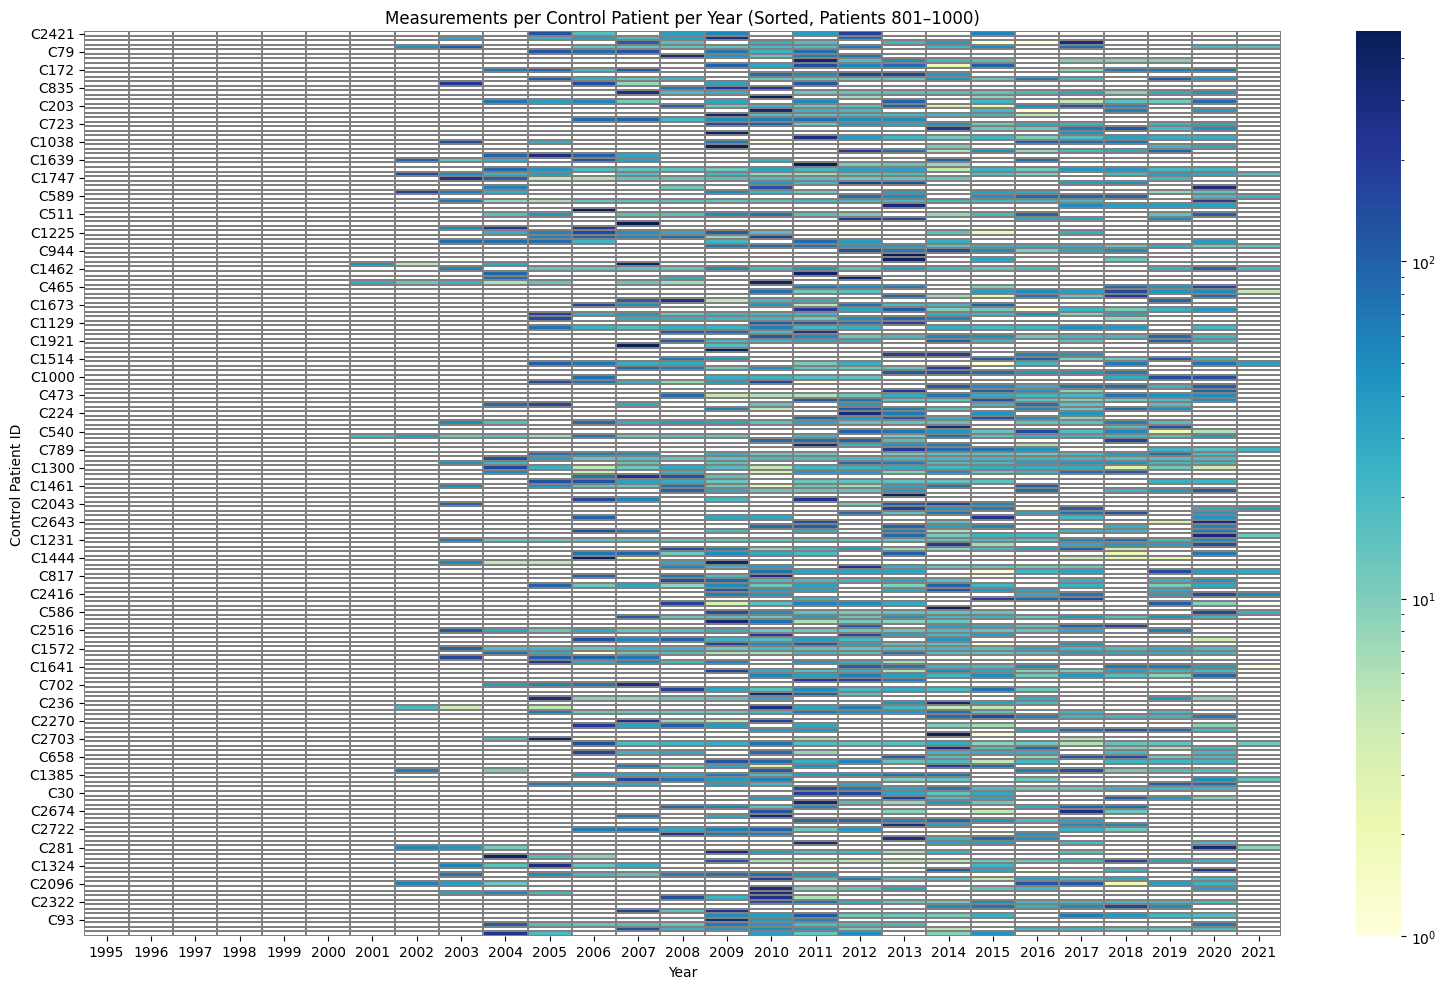

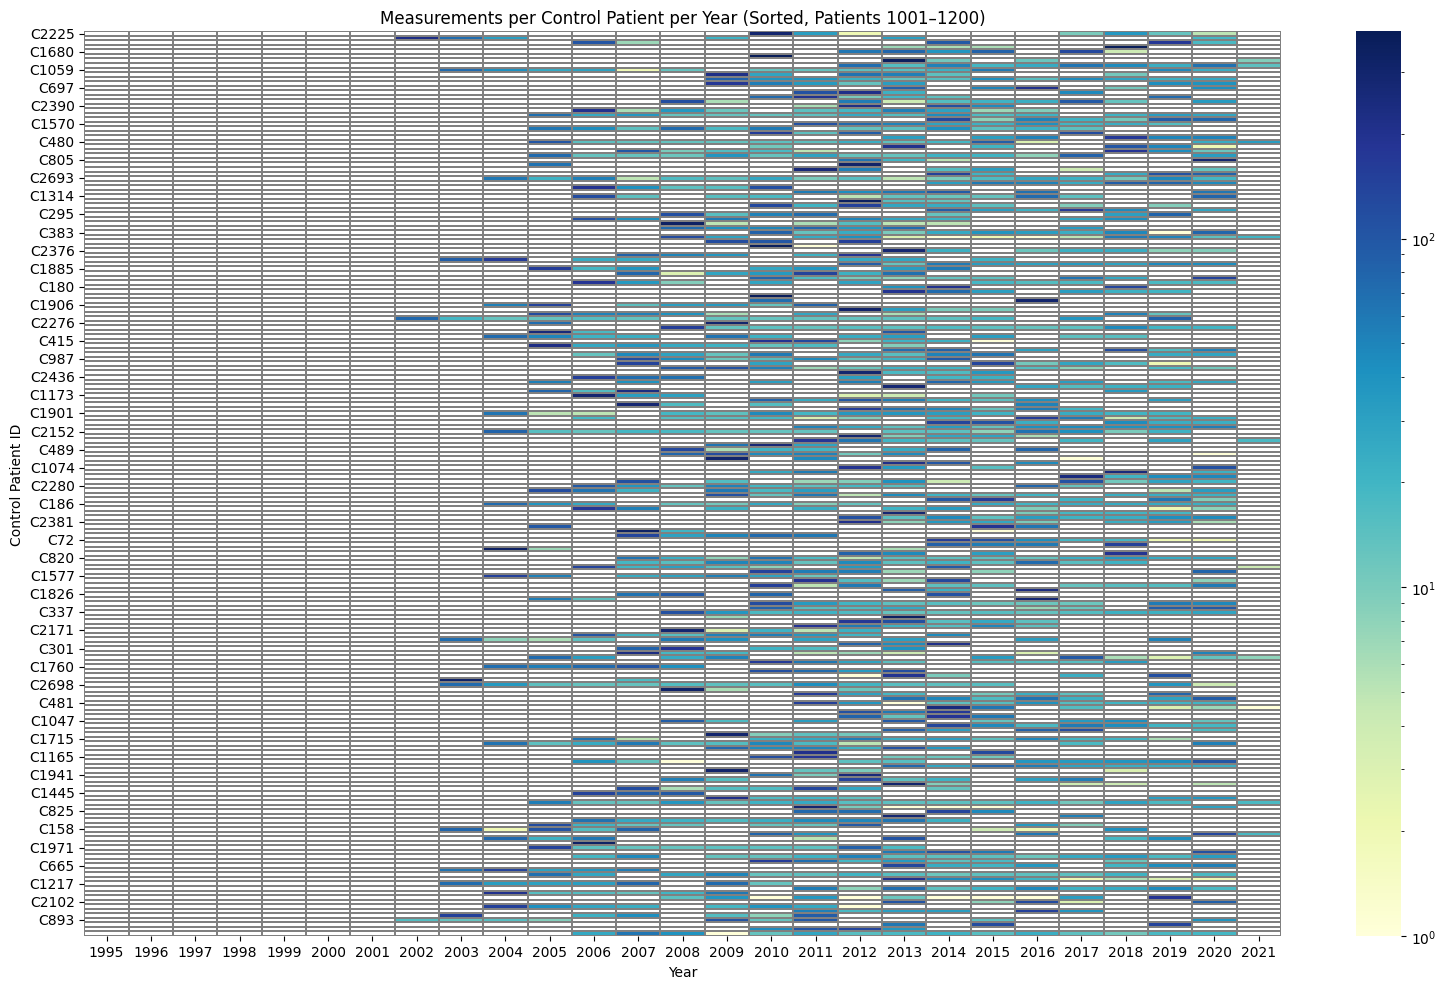

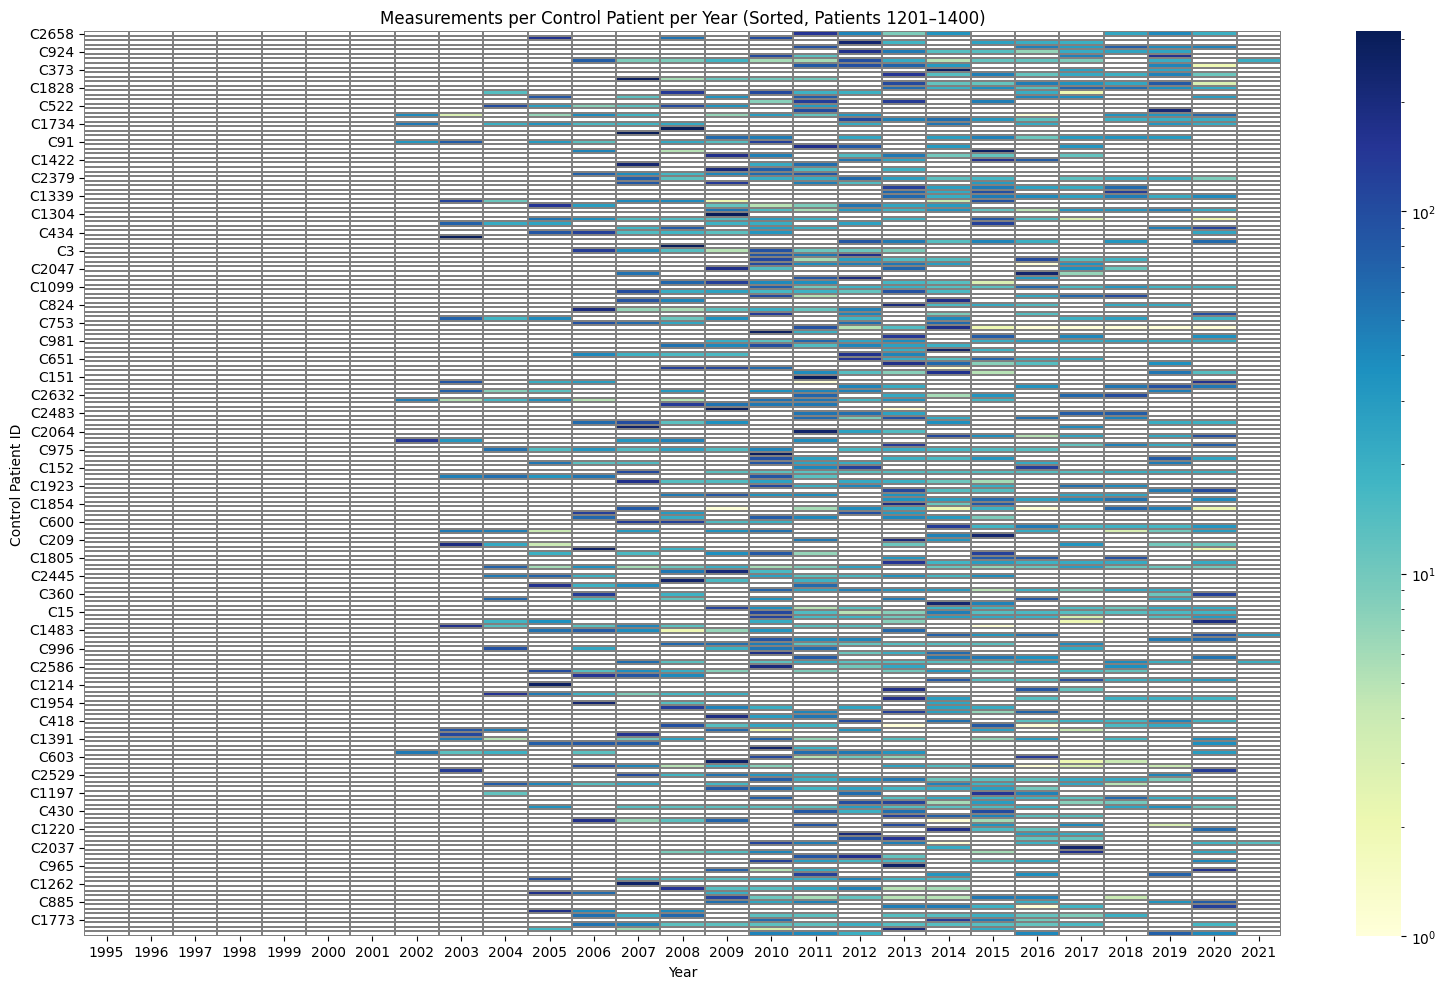

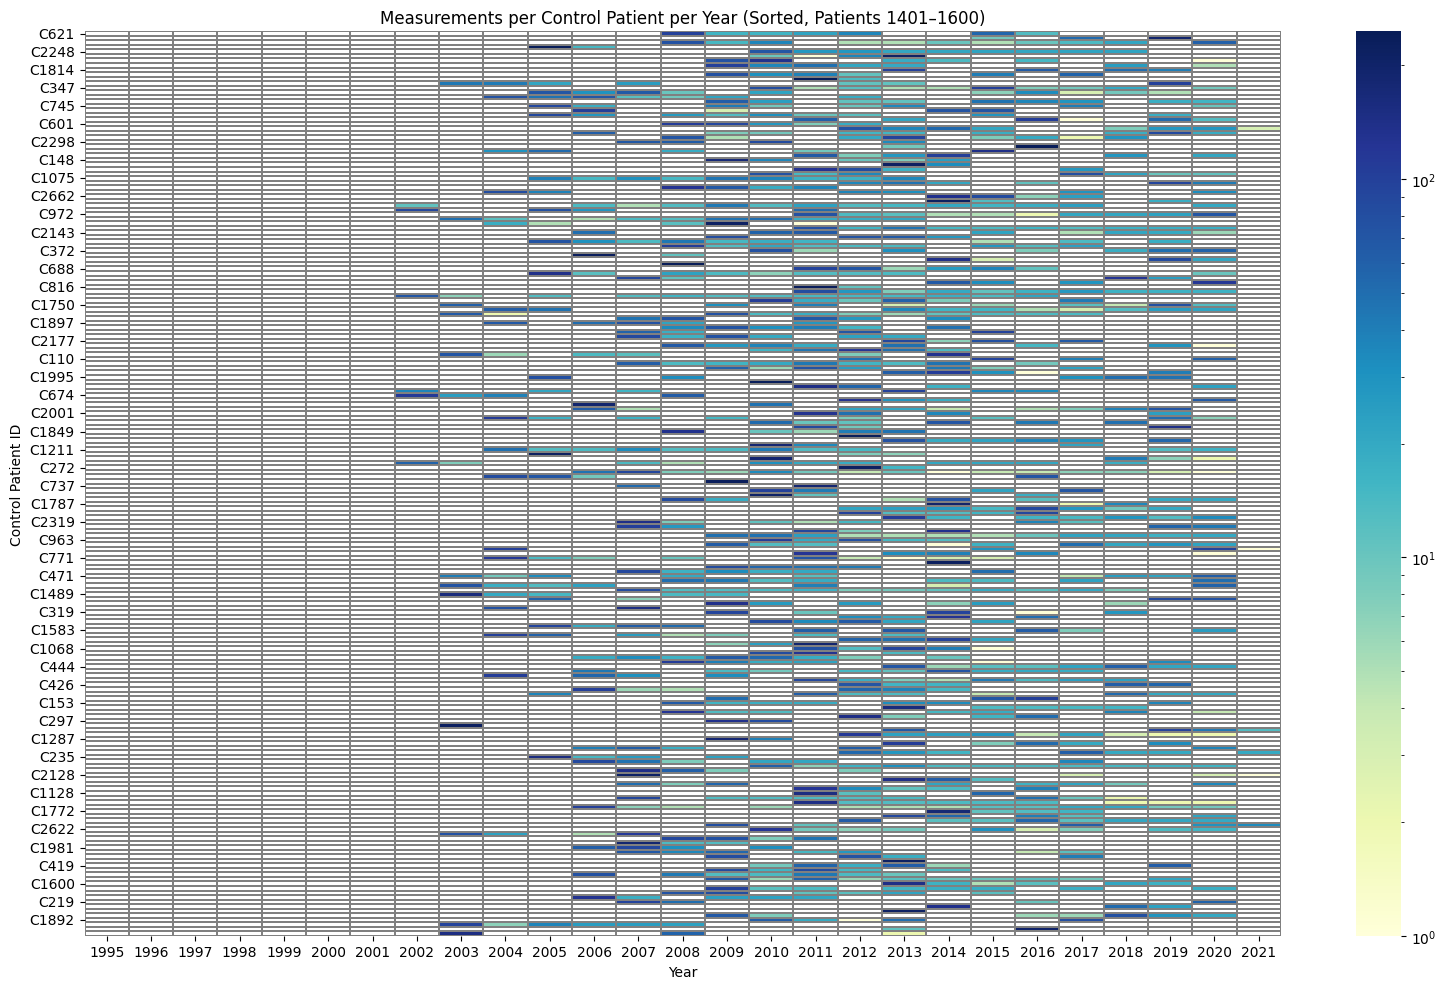

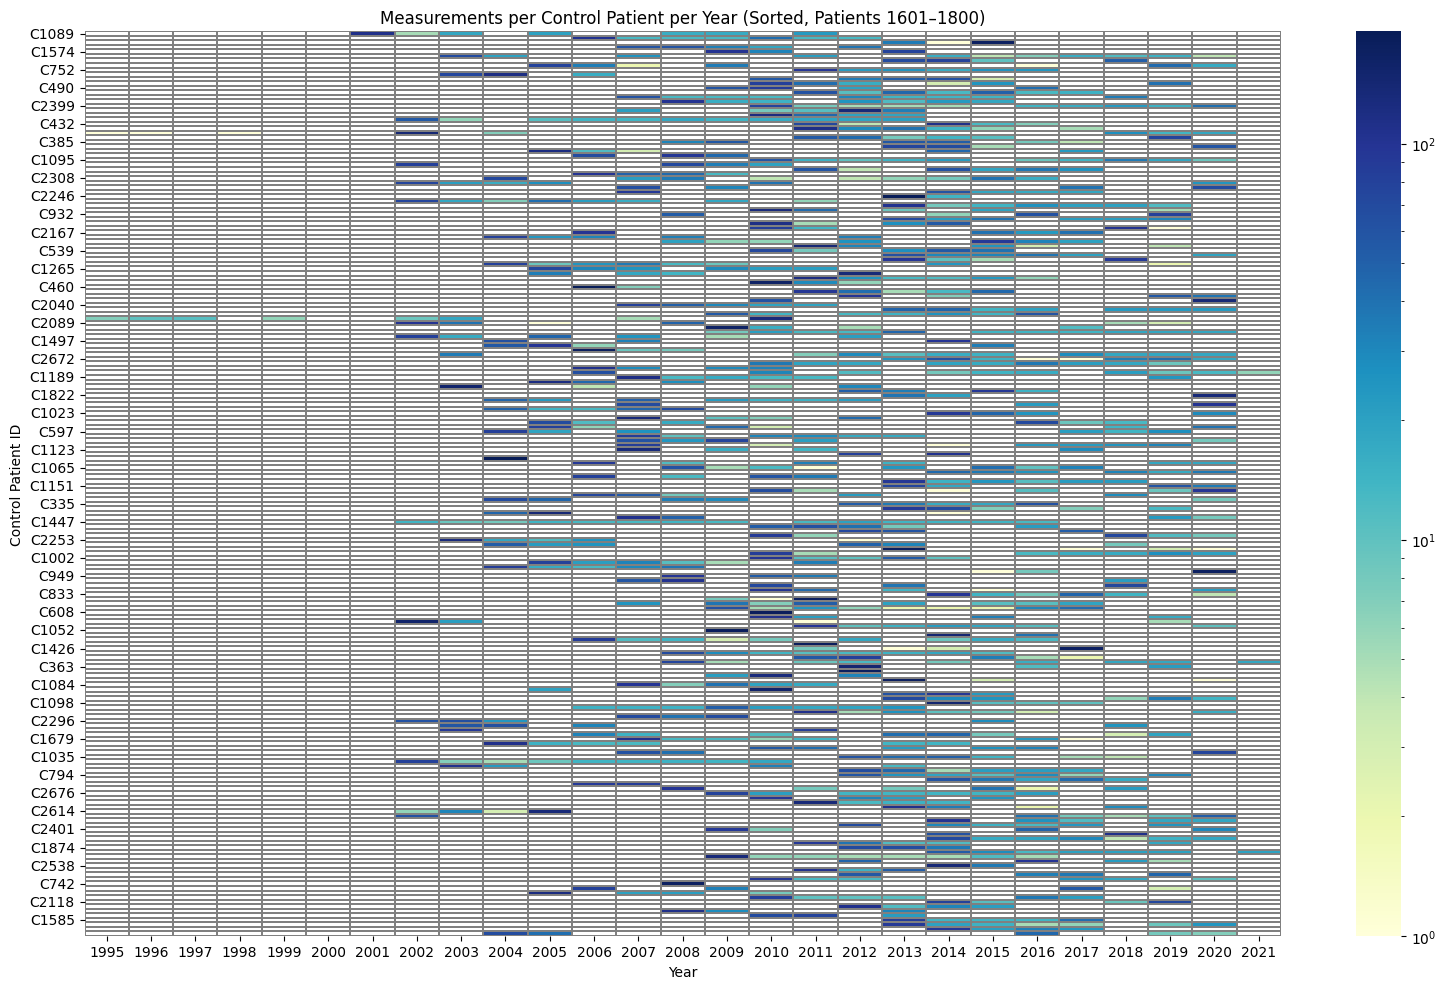

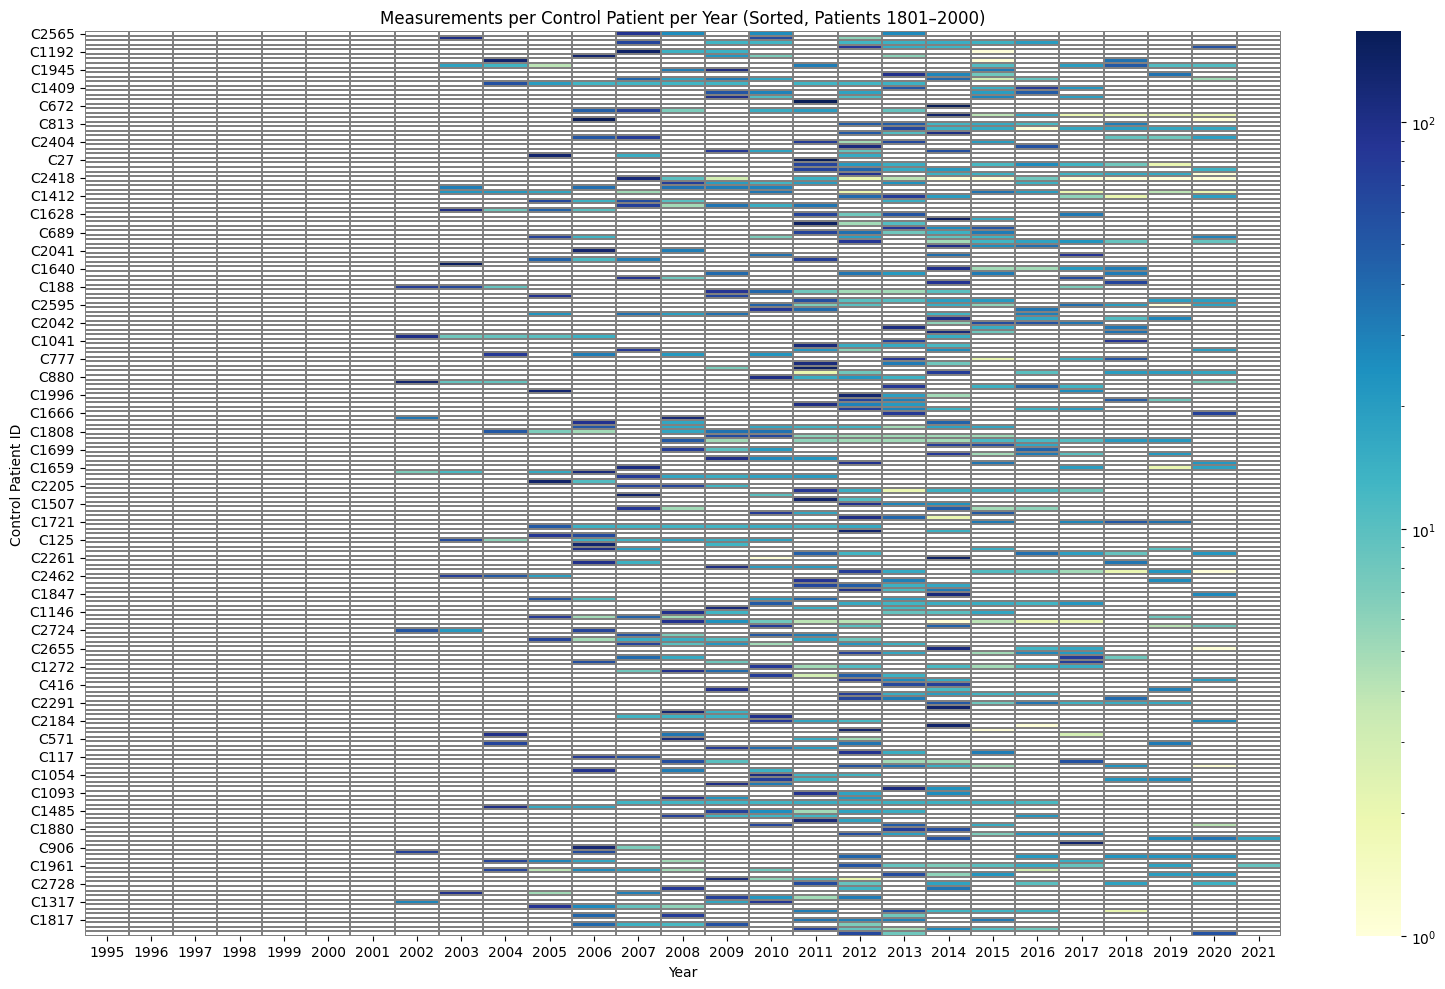

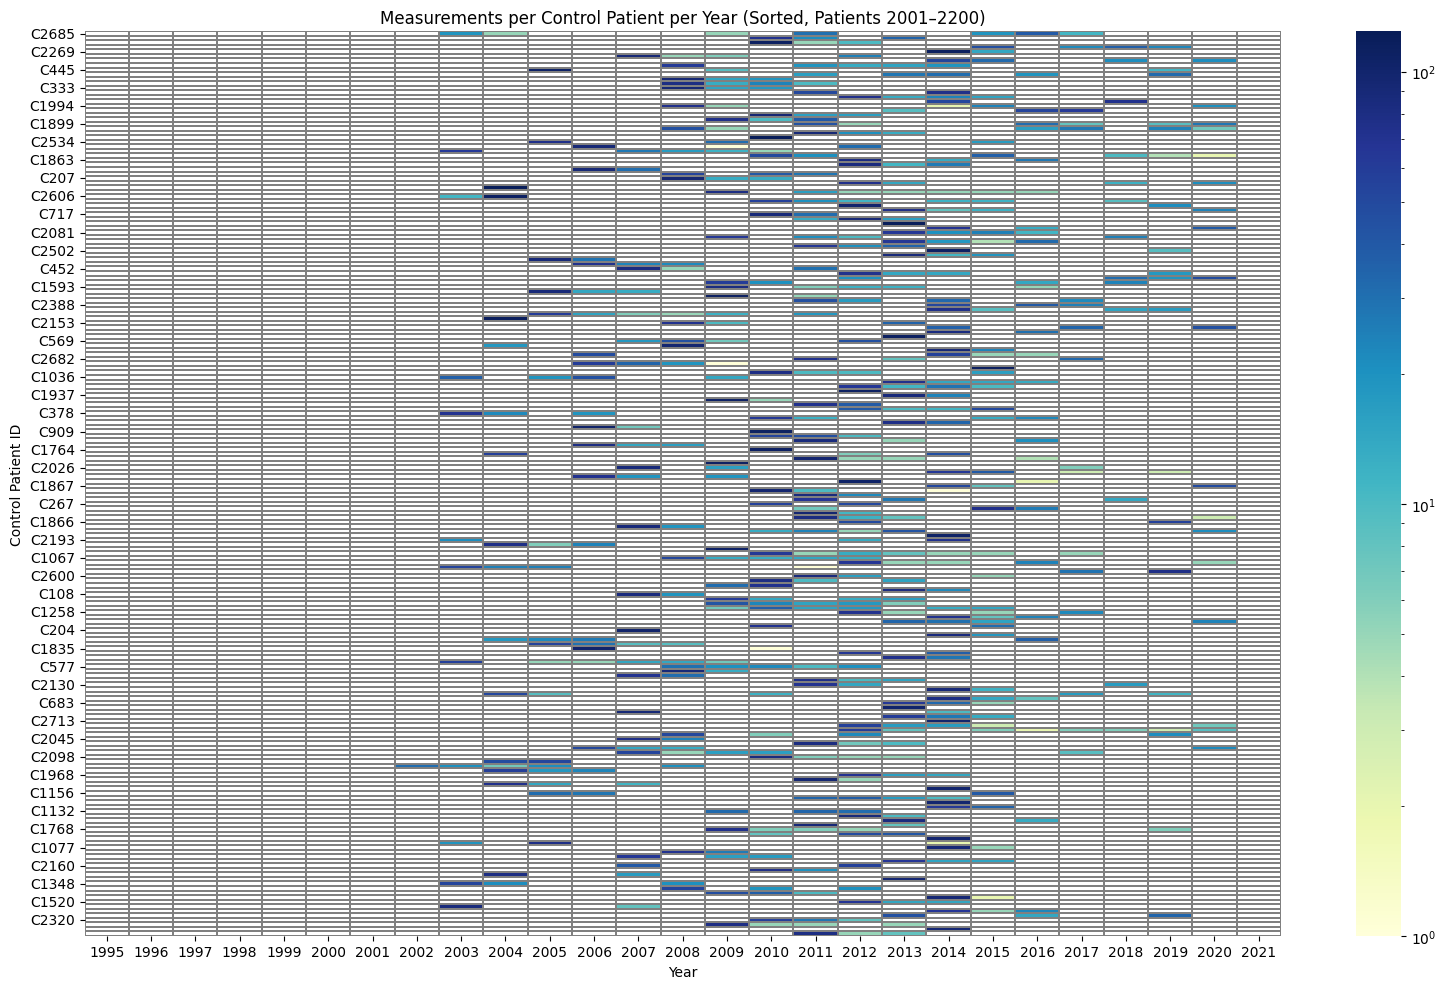

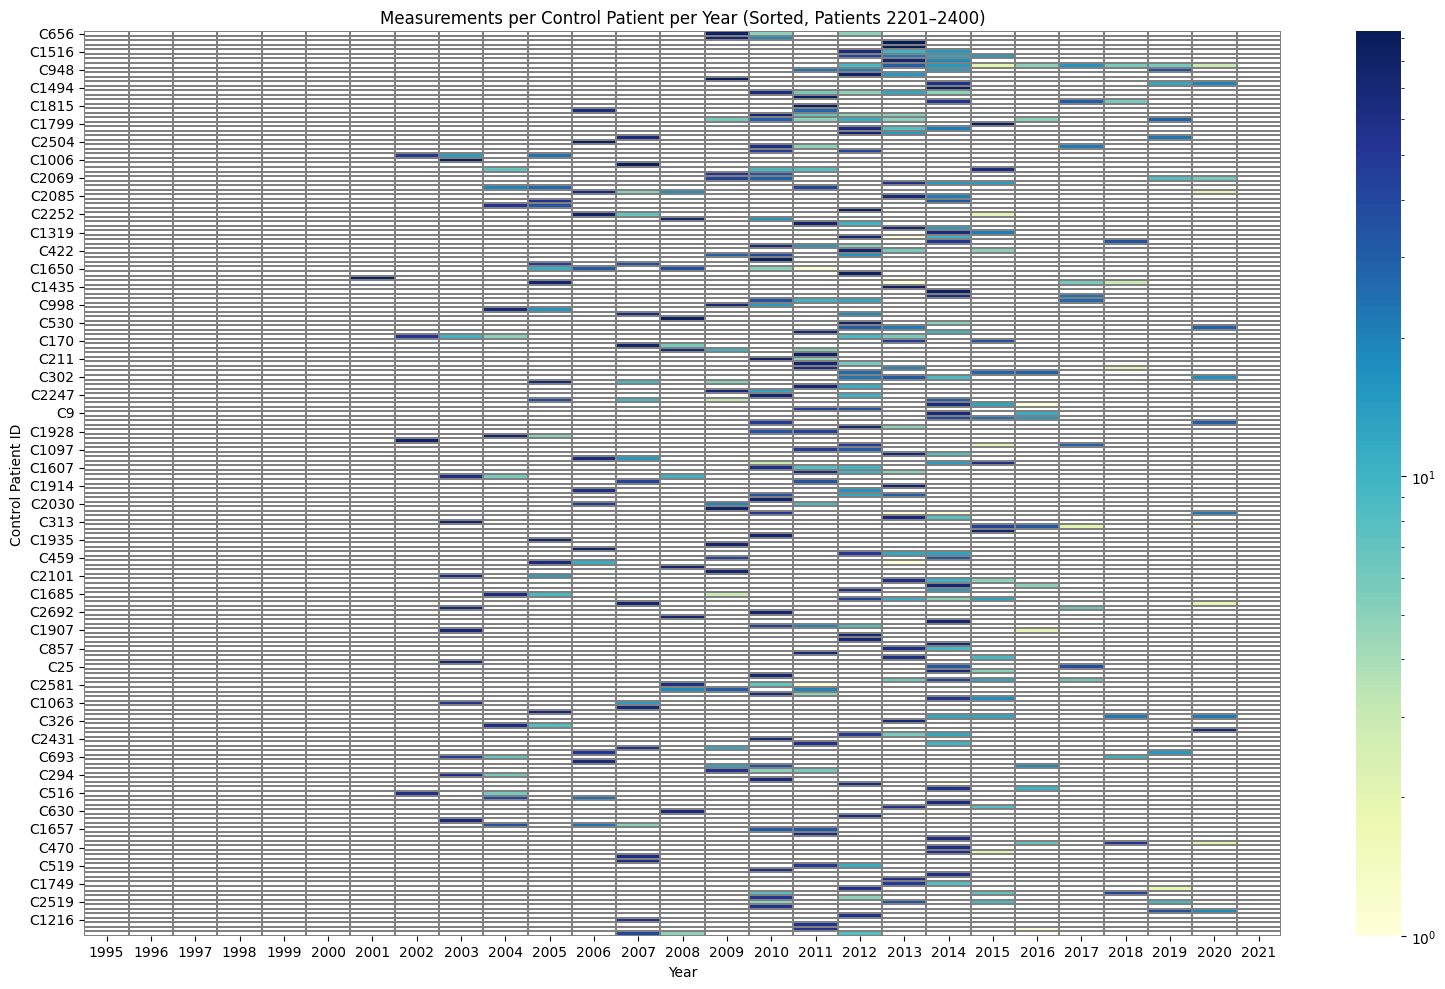

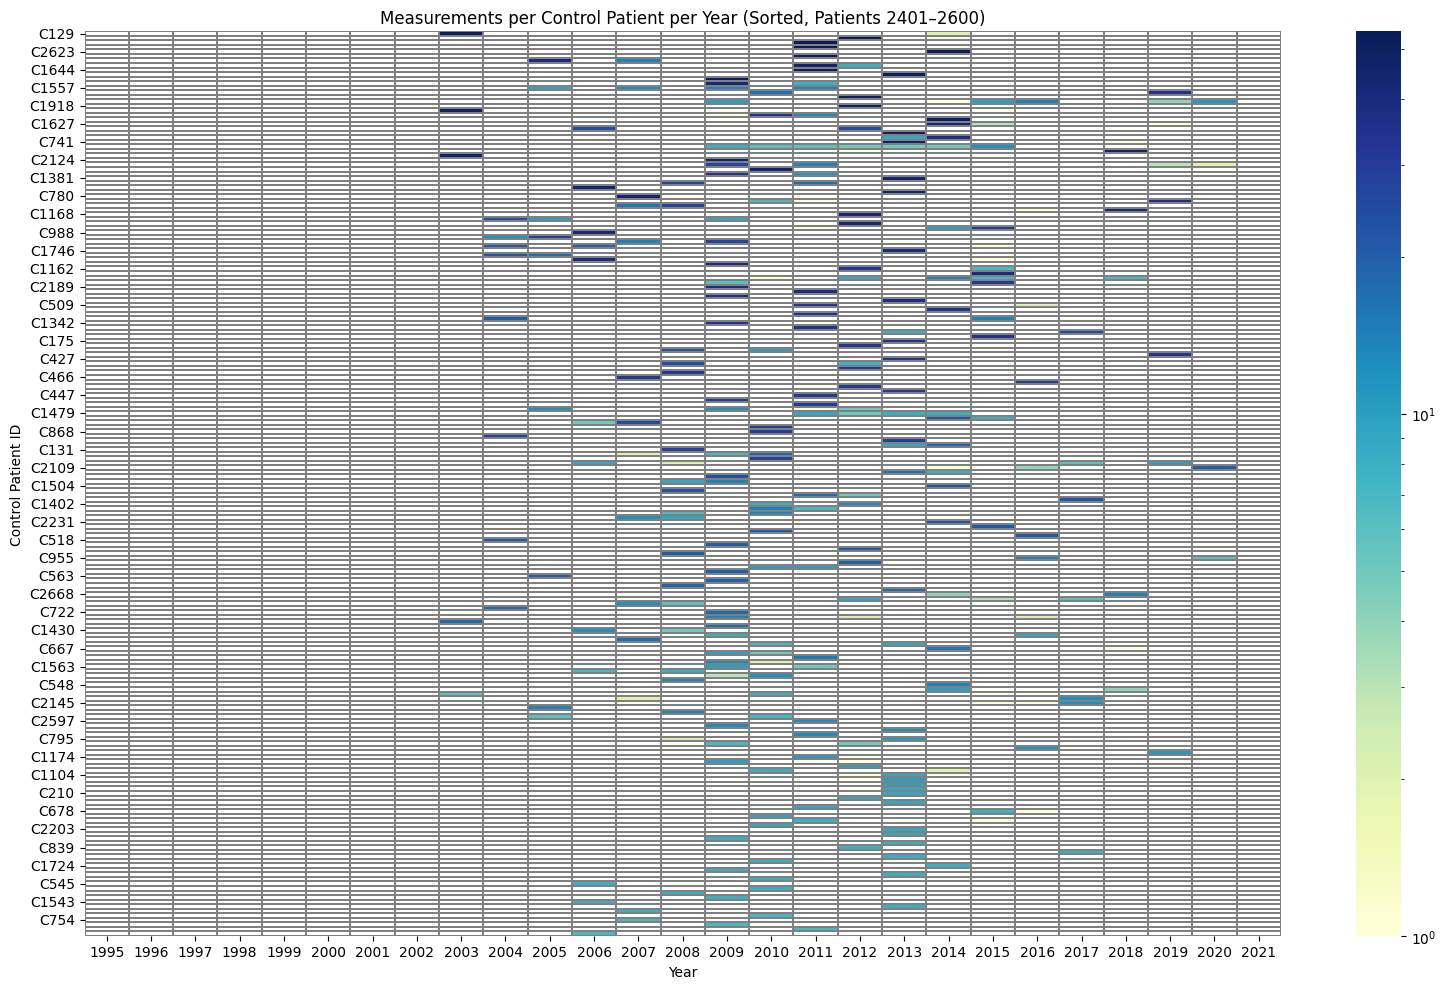

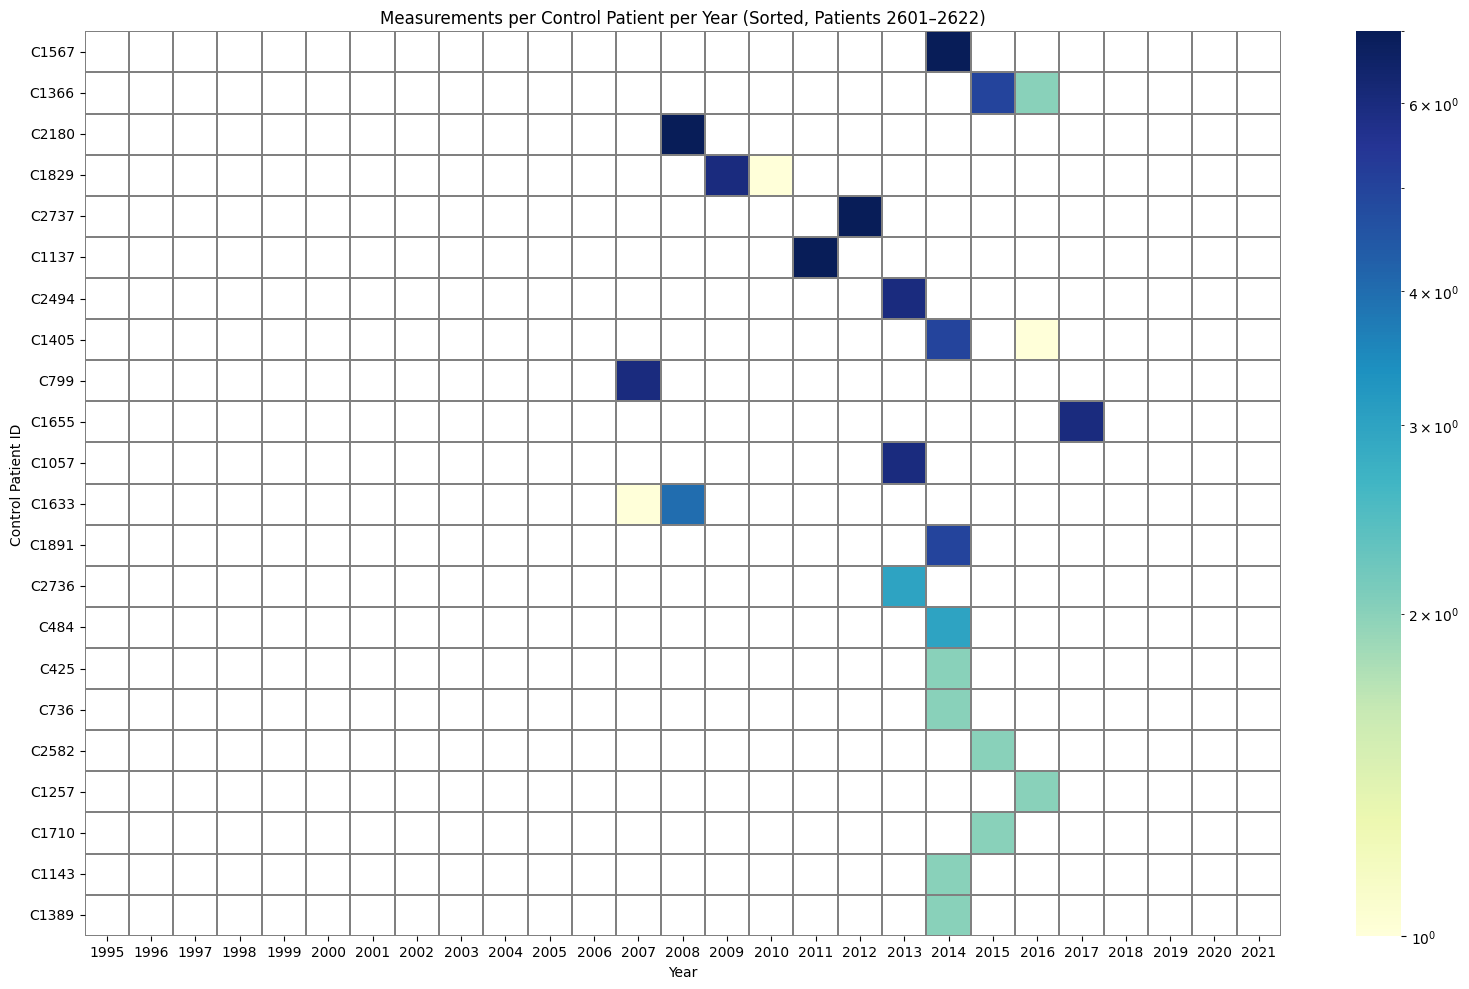

In [ ]:
# Create pivot table (patients x years) counting measurements
heatmap_data = data.pivot_table(index="PatID", columns="Year", values="Oms_Code", aggfunc="count", fill_value=0)

# Add patient group info
patient_groups = data[["PatID", "Group"]].drop_duplicates().set_index("PatID")
heatmap_data = heatmap_data.merge(patient_groups, left_index=True, right_index=True)


# Separate VT and Control
vt_data = heatmap_data[heatmap_data["Group"] == "VT"].drop(columns="Group")
control_data = heatmap_data[heatmap_data["Group"] == "Control"].drop(columns="Group")

# Sort both by total measurements
vt_data = vt_data.loc[vt_data.sum(axis=1).sort_values(ascending=False).index]
control_data = control_data.loc[control_data.sum(axis=1).sort_values(ascending=False).index]

# Heatmap for VT Patients 
plt.figure(figsize=(16, 10))
sns.heatmap(vt_data, cmap="YlGnBu", linewidths=0.1, linecolor="gray", vmin=1, norm=mcolors.LogNorm())
plt.title("Measurements per VT Patient per Year (Sorted)")
plt.xlabel("Year")
plt.ylabel("VT Patient ID")
plt.tight_layout()
plt.show()

# Heatmaps for Control Patients in Batches of 200
batch_size = 200
total_controls = control_data.shape[0]
num_batches = (total_controls // batch_size) + 1

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    subset = control_data.iloc[start:end]

    if subset.empty:
        continue

    plt.figure(figsize=(16, 10))
    sns.heatmap(subset, cmap="YlGnBu", linewidths=0.1, linecolor="gray", vmin=1, norm=mcolors.LogNorm())
    plt.title(f"Measurements per Control Patient per Year (Sorted, Patients {start + 1}–{min(end, total_controls)})")
    plt.xlabel("Year")
    plt.ylabel("Control Patient ID")
    plt.tight_layout()
    plt.show()


scale the years to be 0 = year of infarction and 1 = end date or vt date

In [ ]:
# Ensure all date columns are in datetime format
data["Date (s)"] = pd.to_datetime(data["Date (s)"], errors="coerce")
data["First MI date (s)"] = pd.to_datetime(data["First MI date (s)"], errors="coerce")
data["Upper Date (s)"] = pd.to_datetime(data["Upper Date (s)"], errors="coerce")

# Calculate normalized time
data["Normalized Time"] = (
    (data["Date (s)"] - data["First MI date (s)"]).dt.total_seconds() /
    (data["Upper Date (s)"] - data["First MI date (s)"]).dt.total_seconds()
)


In [ ]:
# Create bins for normalized time 
num_bins = 21
data["Time Bin"] = pd.cut(data["Normalized Time"], bins=np.linspace(0, 1, num_bins + 1), labels=False)

# Create pivot: rows = patients, columns = normalized bins, values = count of tests
heatmap_relative = data.pivot_table(index="PatID", columns="Time Bin", values="Oms_Code", aggfunc="count", fill_value=0)

In [ ]:
# Merge group info
patient_groups = data[["PatID", "Group"]].drop_duplicates().set_index("PatID")
heatmap_relative = heatmap_relative.merge(patient_groups, left_index=True, right_index=True)

# Separate and sort
vt_relative = heatmap_relative[heatmap_relative["Group"] == "VT"].drop(columns="Group")
control_relative = heatmap_relative[heatmap_relative["Group"] == "Control"].drop(columns="Group")

vt_relative = vt_relative.loc[vt_relative.sum(axis=1).sort_values(ascending=False).index]
control_relative = control_relative.loc[control_relative.sum(axis=1).sort_values(ascending=False).index]

# VT heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(vt_relative, cmap="YlGnBu", linewidths=0.1, linecolor="gray", vmin=1, norm=mcolors.LogNorm())
plt.title("Normalized Time (0–1) - Measurements per VT Patient")
plt.xlabel("Normalized Time Bin")
plt.ylabel("VT Patient ID")
plt.tight_layout()
plt.savefig("heatmaps/vt_patient_heatmap.pdf", format="pdf", bbox_inches='tight')
plt.close()

# control heatmaps in batches of 200
batch_size = 200
total_controls = control_relative.shape[0]
num_batches = (total_controls // batch_size) + 1

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    subset = control_relative.iloc[start:end]

    if subset.empty:
        continue

    plt.figure(figsize=(16, 10))
    sns.heatmap(subset, cmap="YlGnBu", linewidths=0.1, linecolor="gray", vmin=1, norm=mcolors.LogNorm())
    plt.title(f"Normalized Time - Control Patients {start + 1} to {min(end, total_controls)}")
    plt.xlabel("Normalized Time Bin")
    plt.ylabel("Control Patient ID")
    plt.tight_layout()
    filename = f"heatmaps/control_patient_heatmap_{start + 1}_{min(end, total_controls)}.pdf"
    plt.savefig(filename, format="pdf", bbox_inches='tight')
    plt.close()

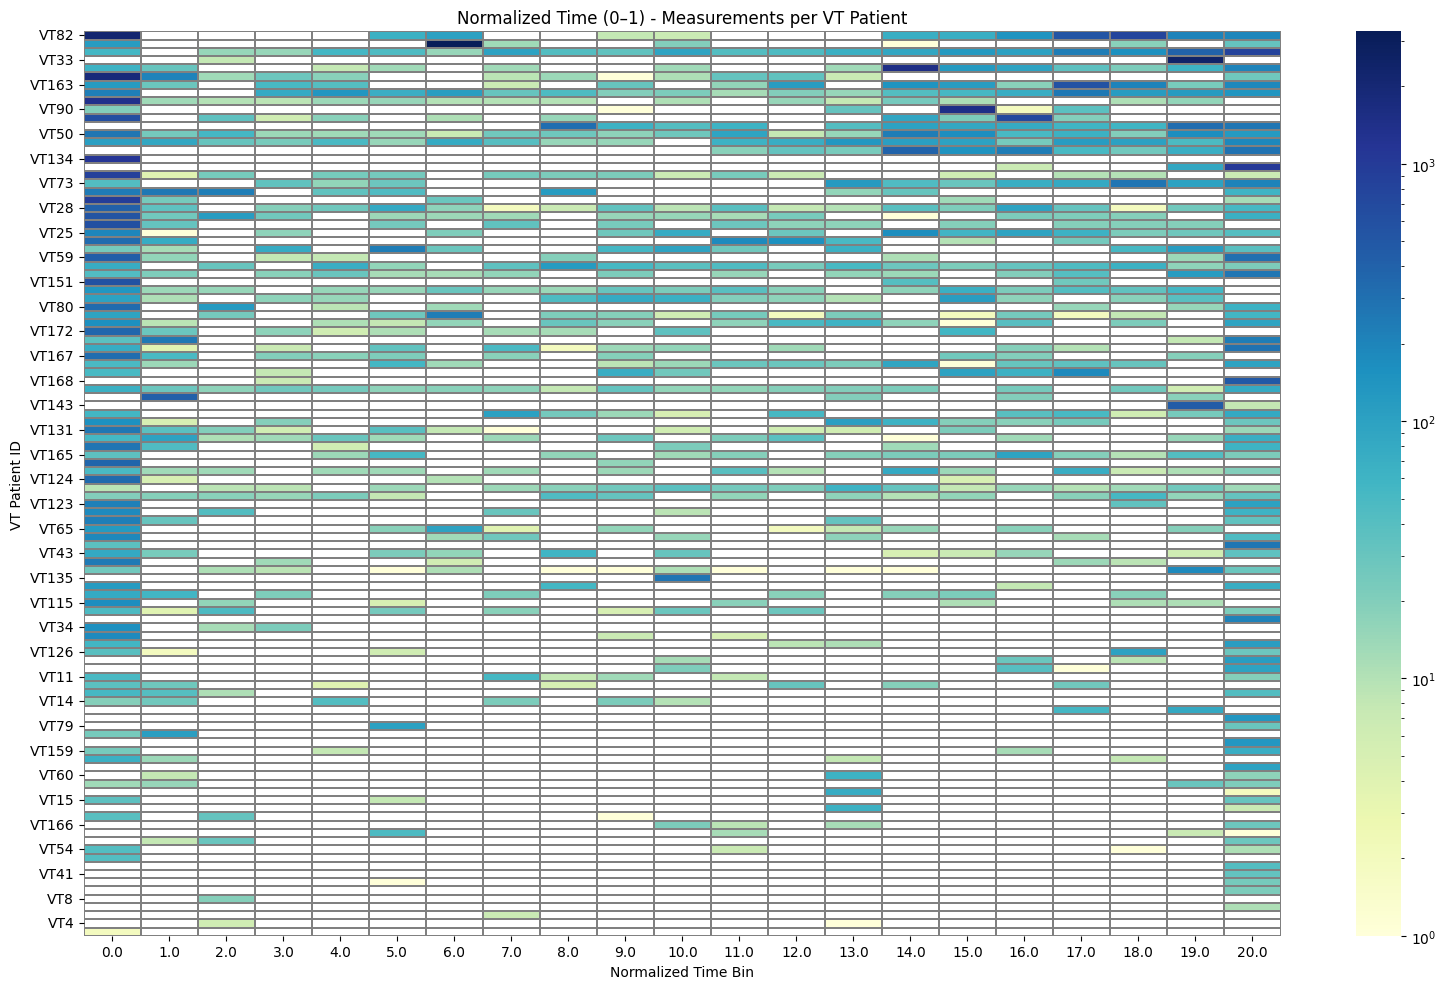

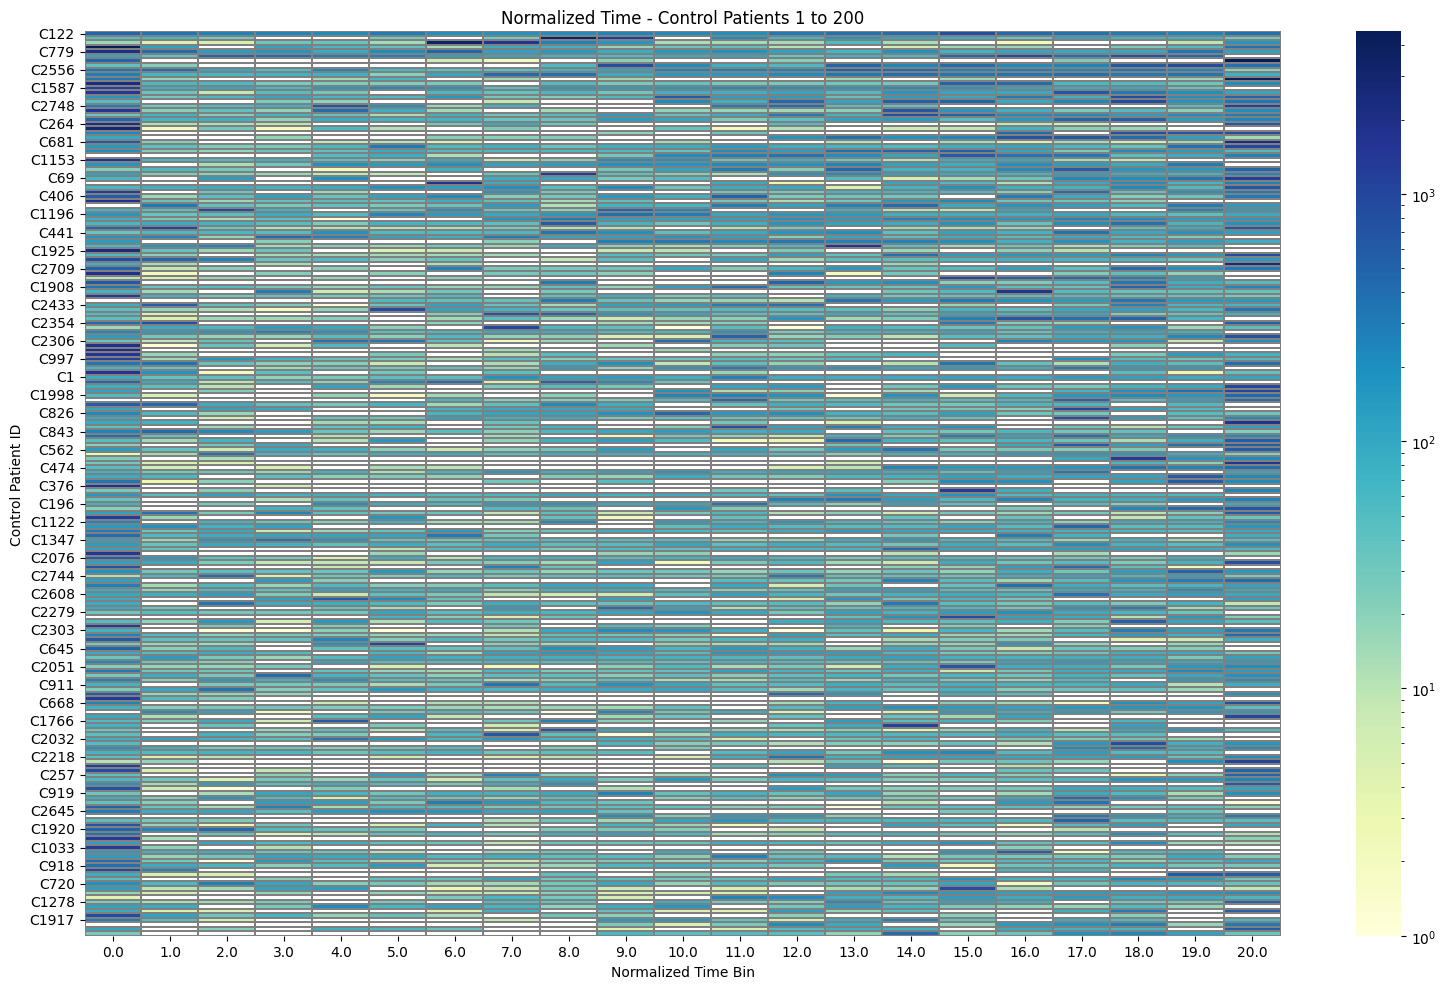

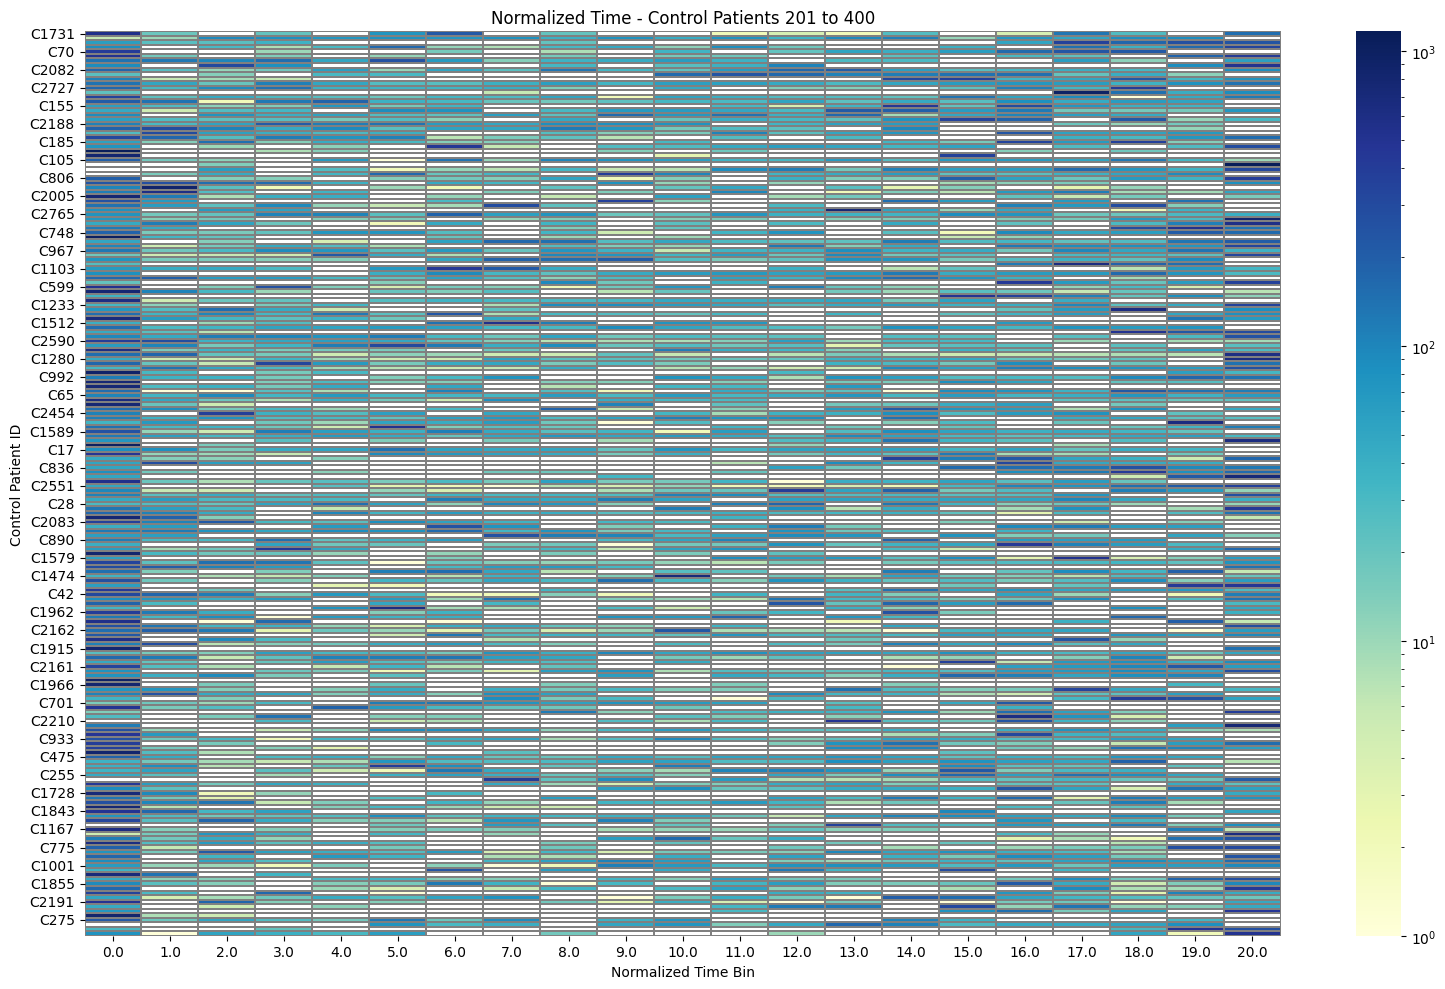

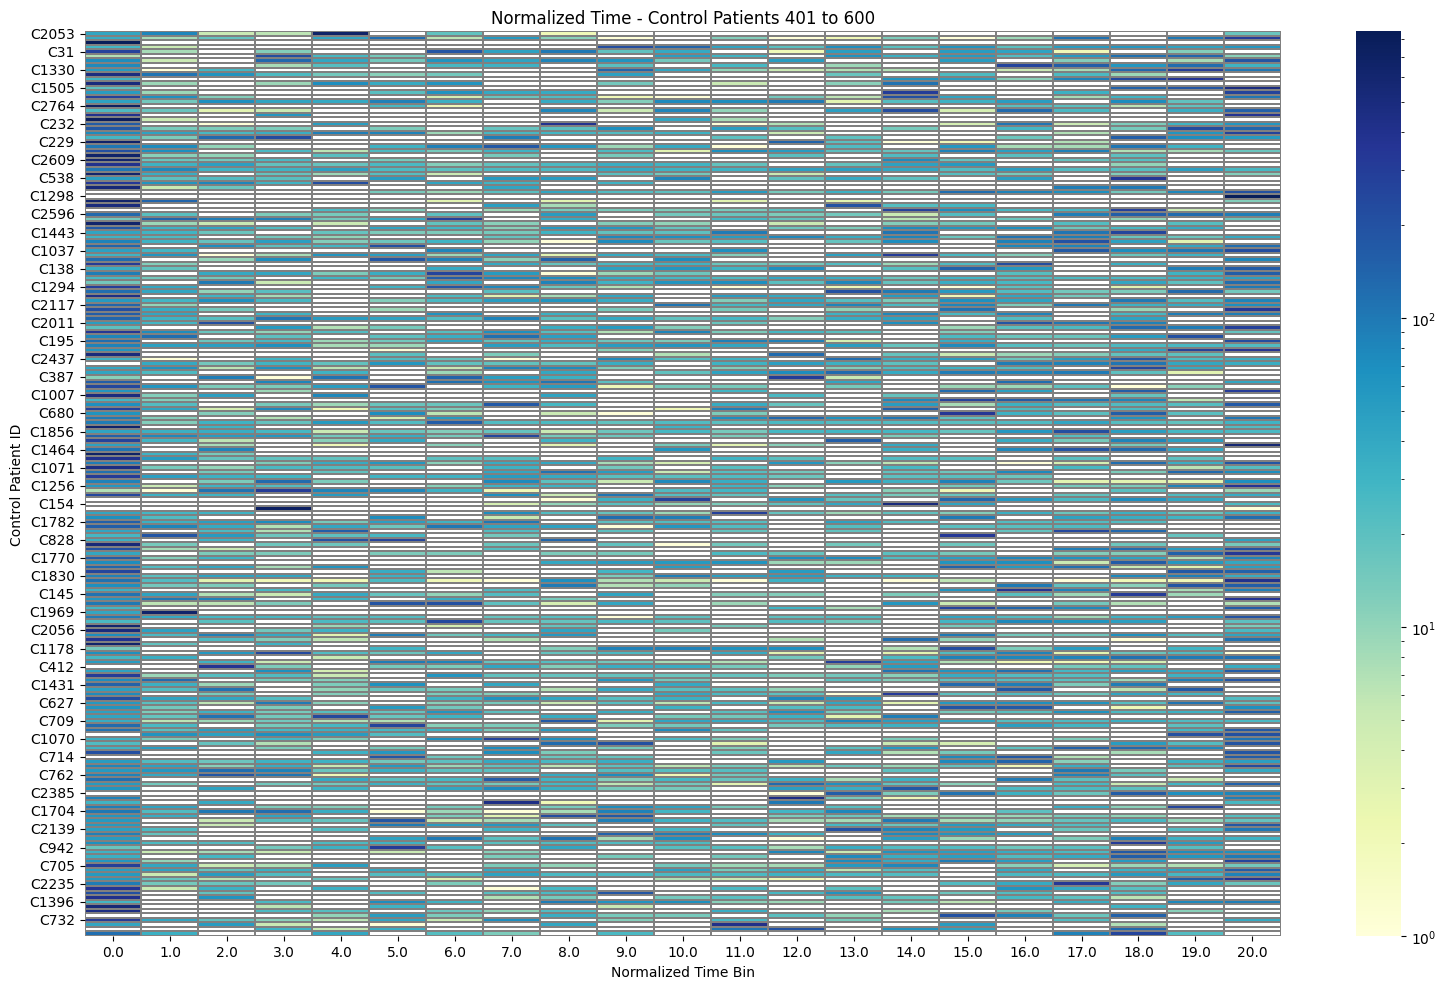

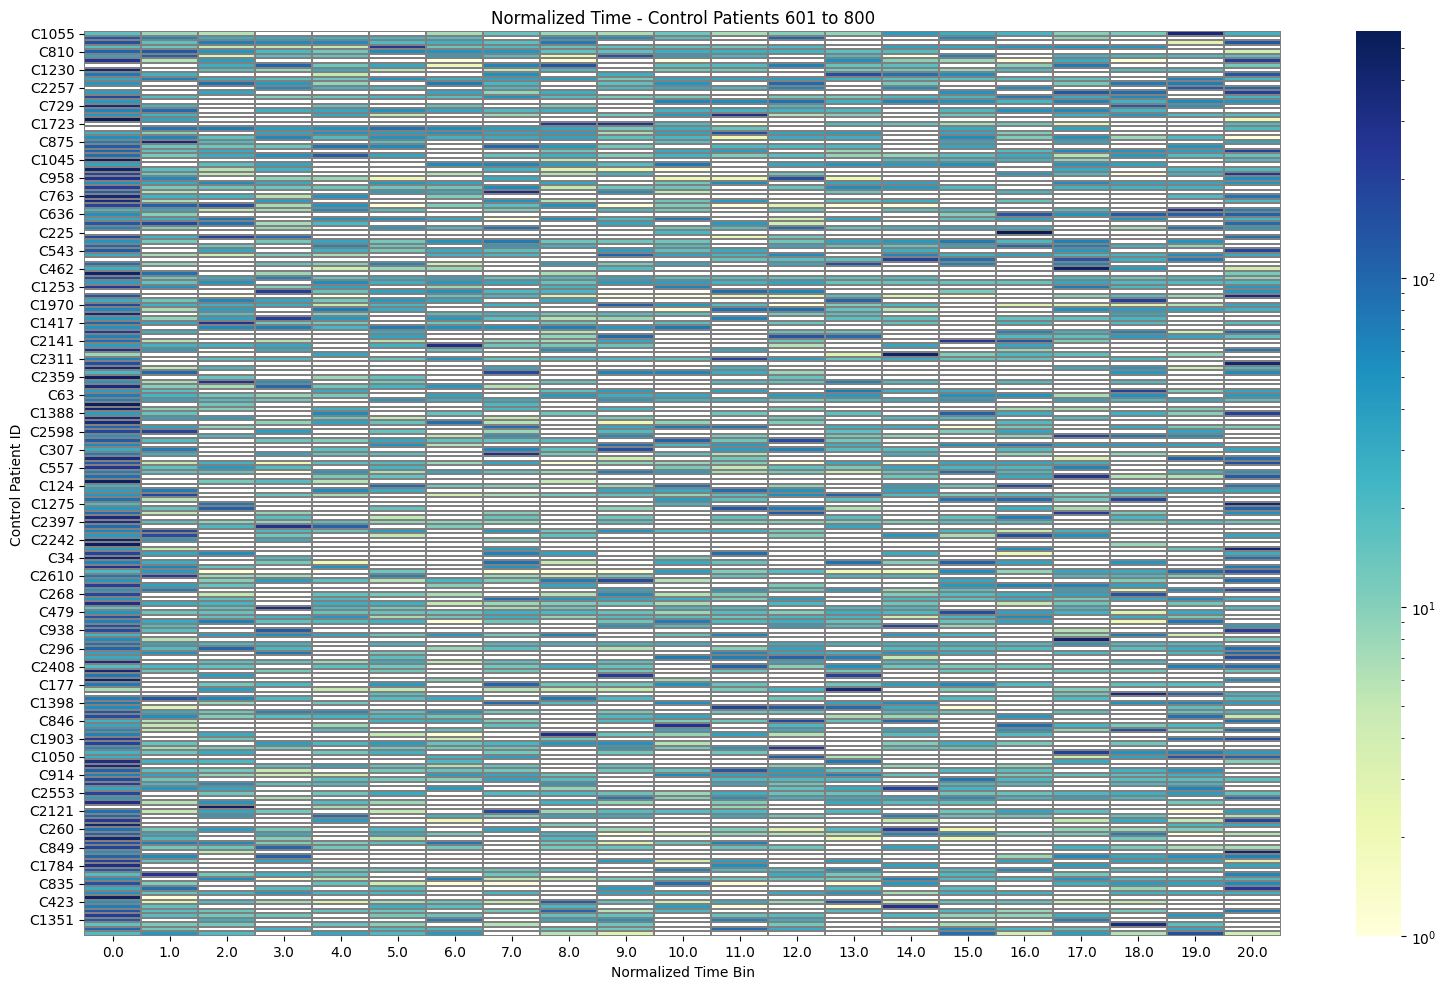

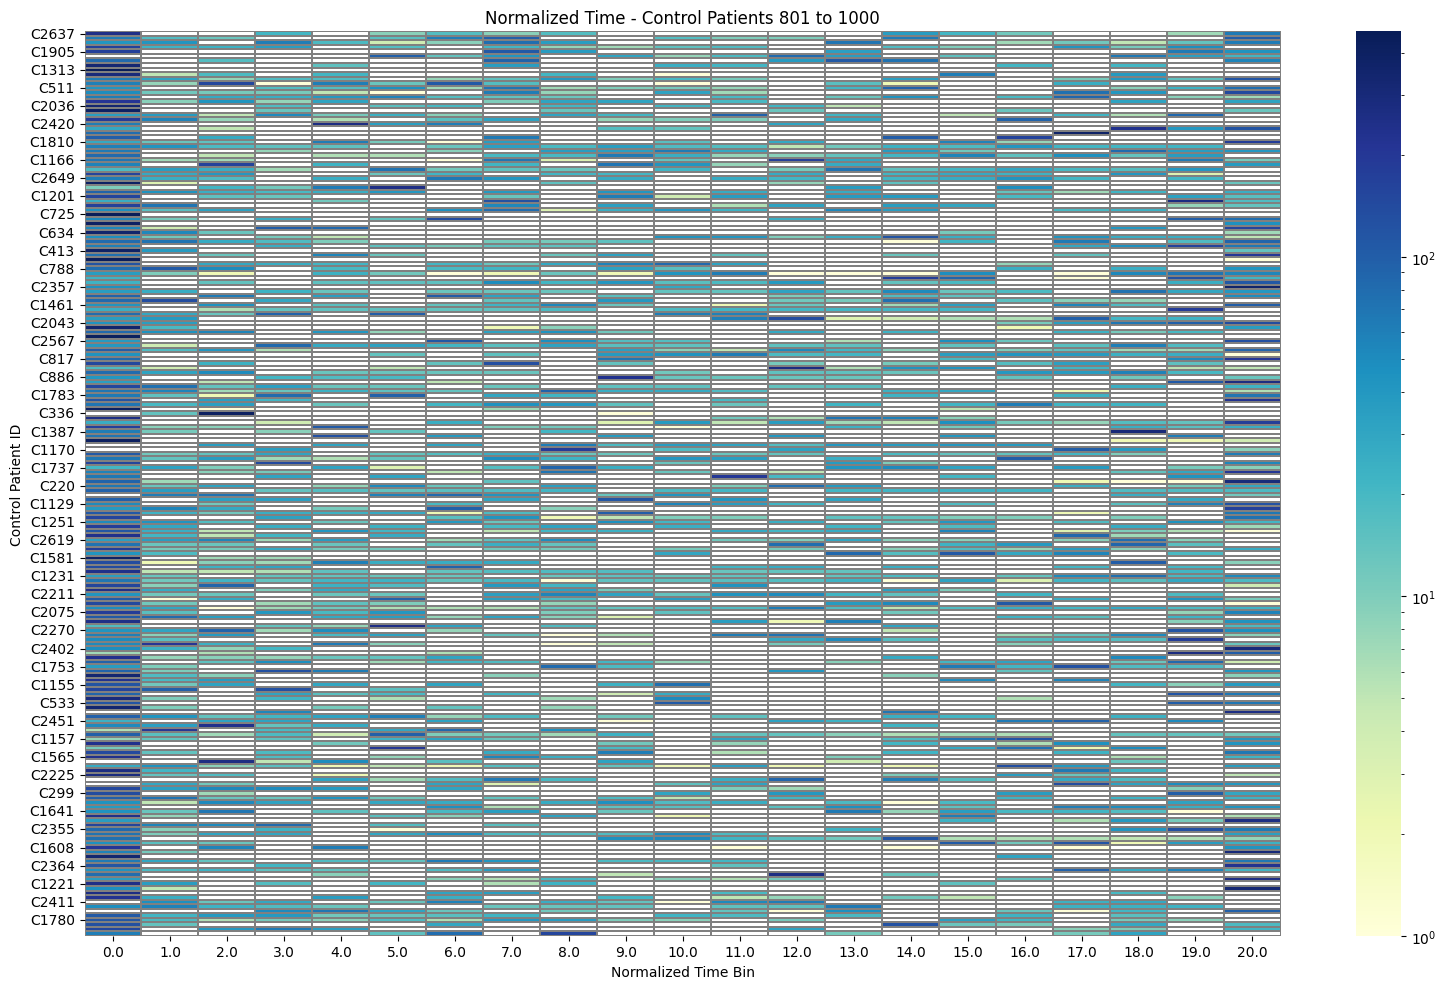

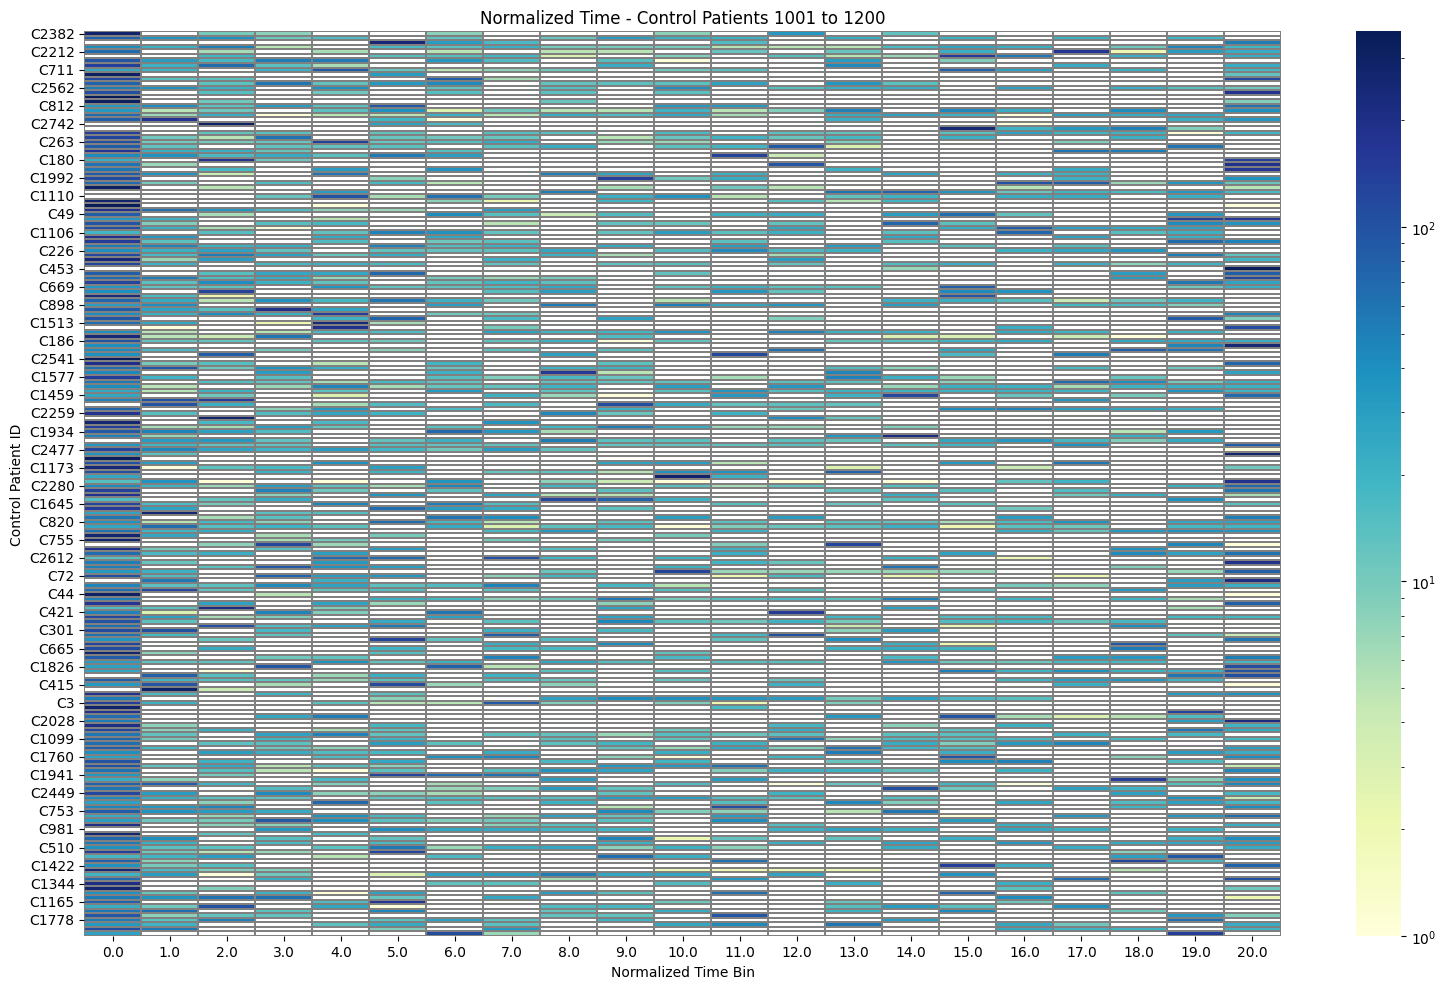

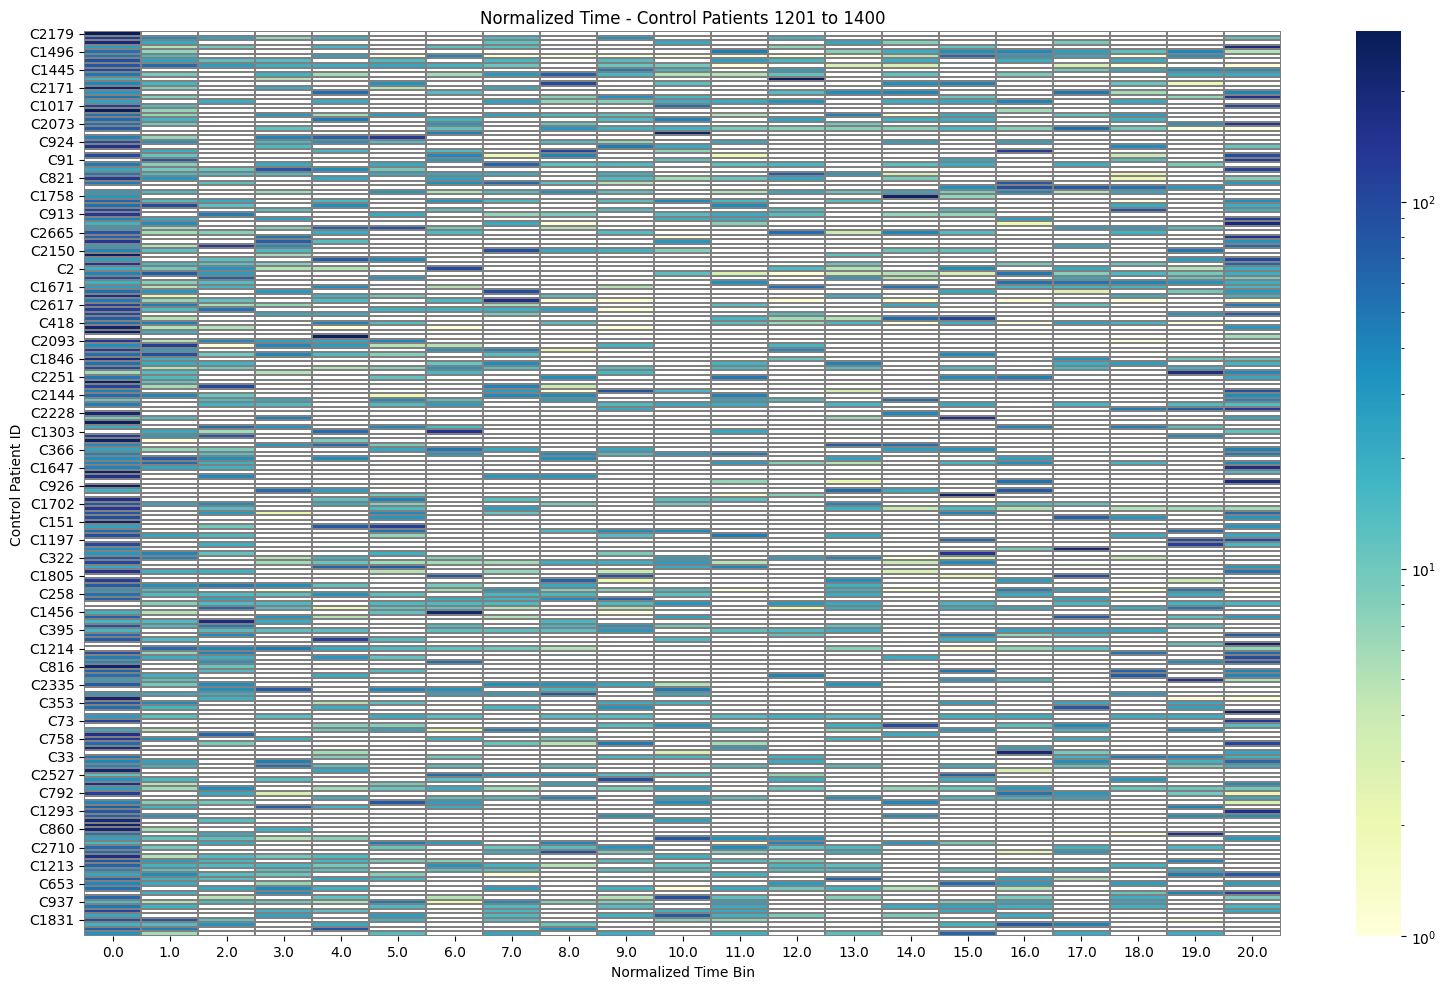

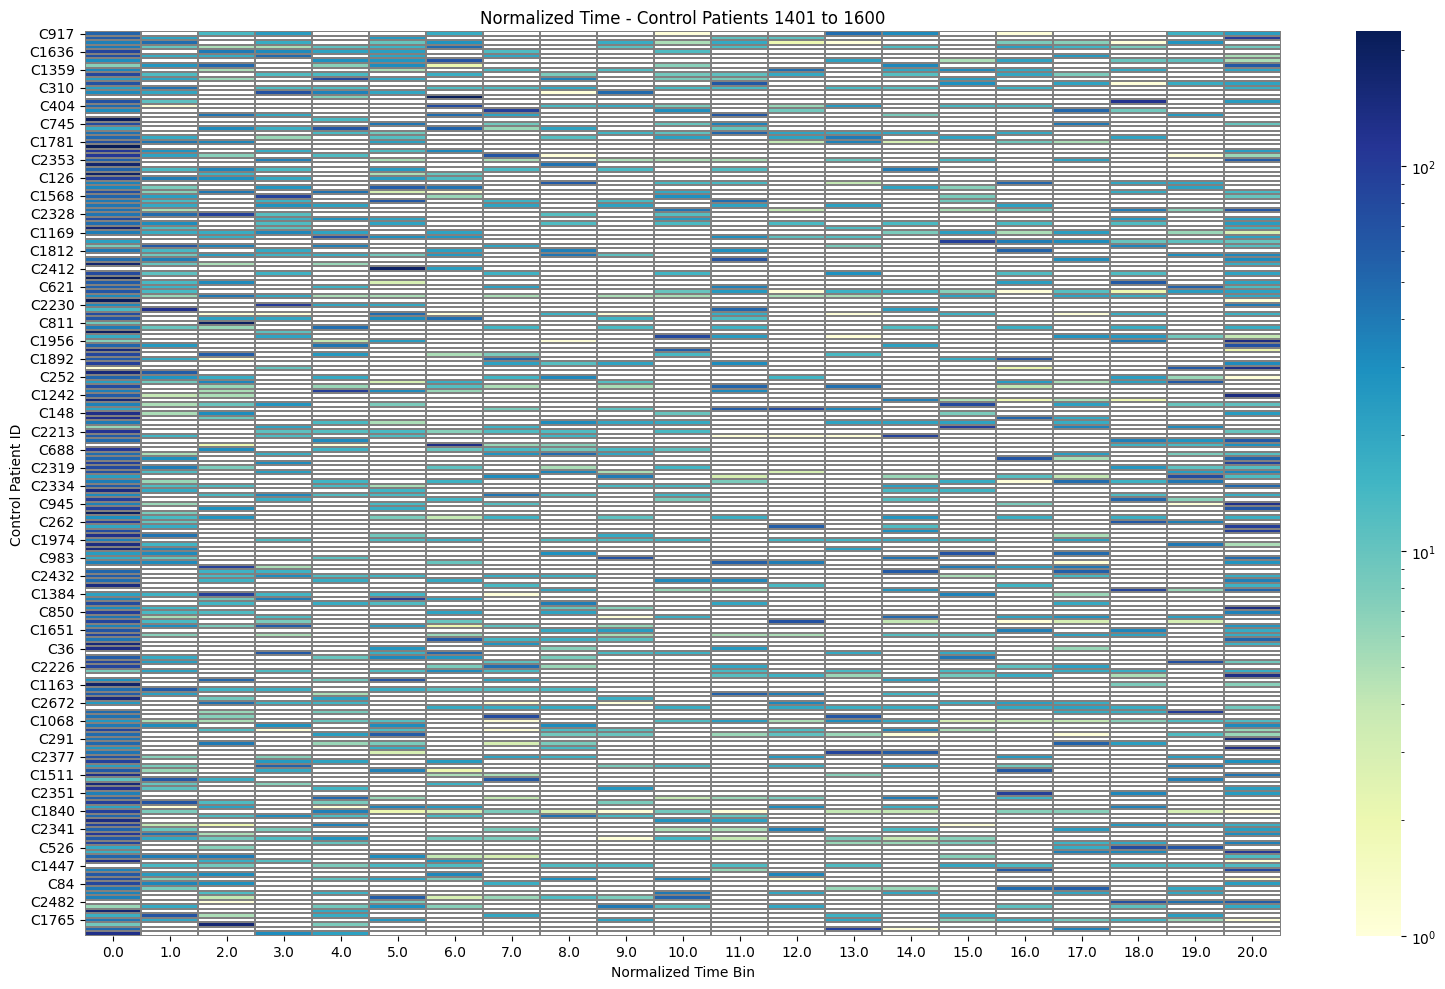

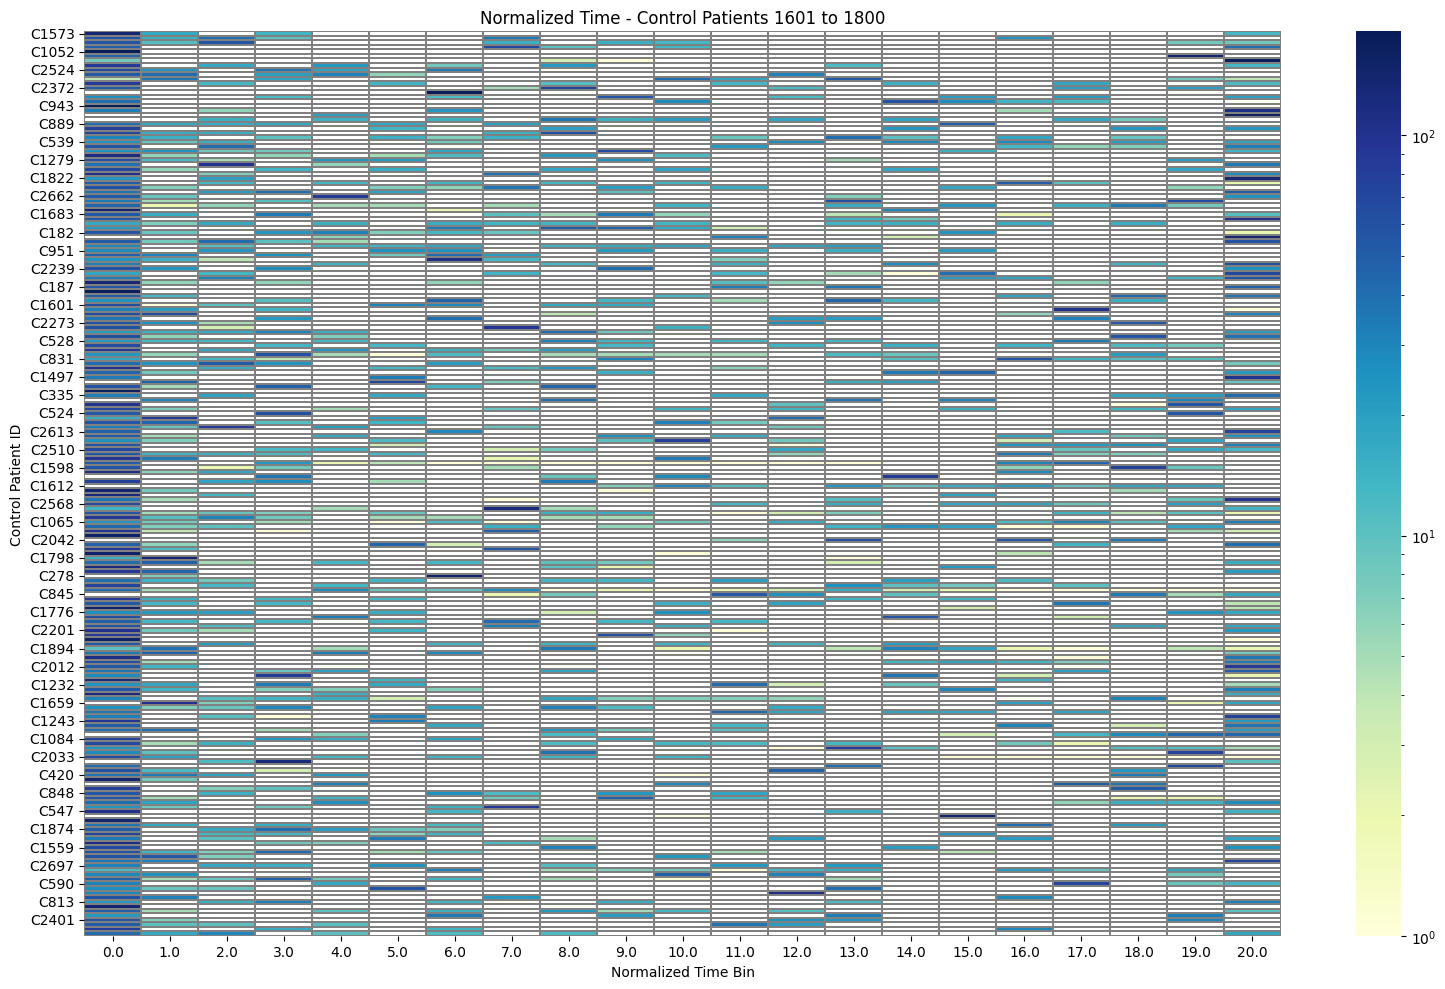

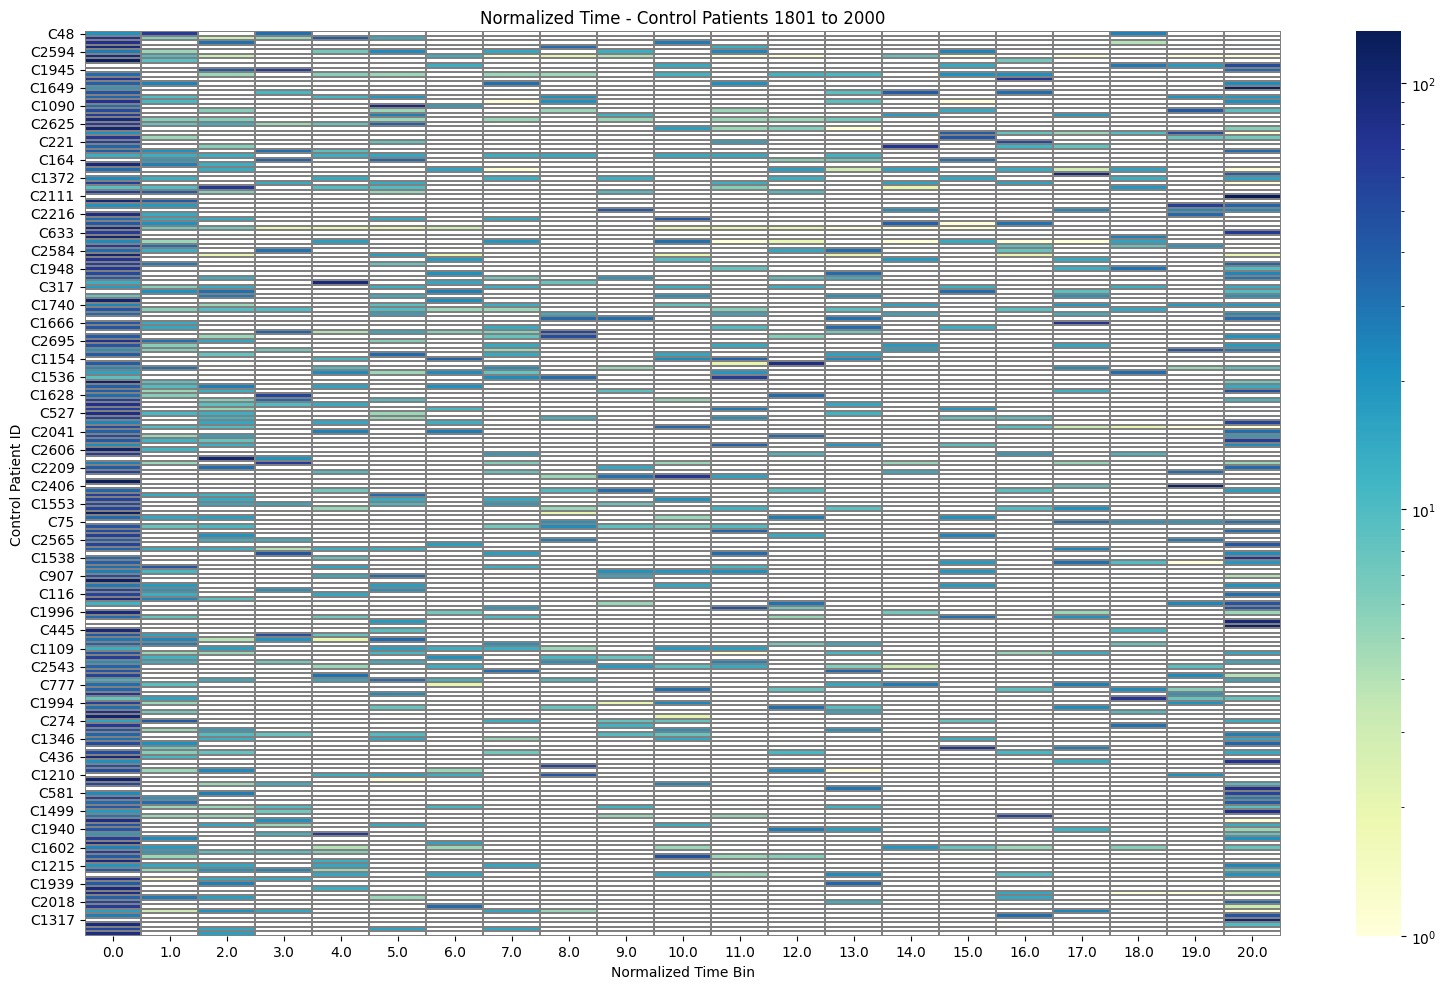

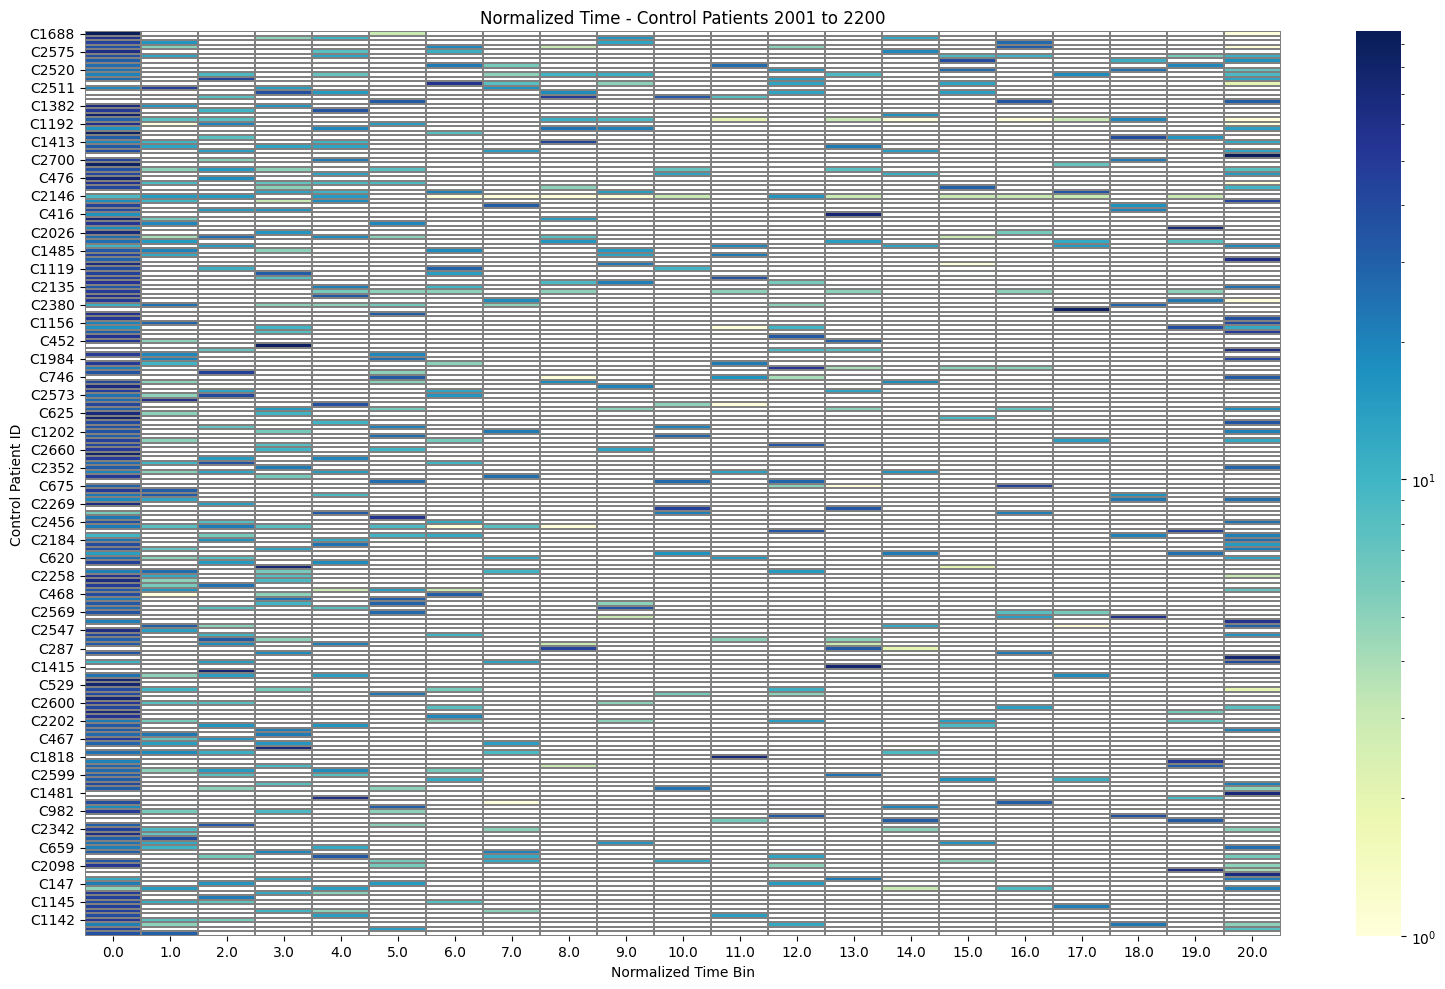

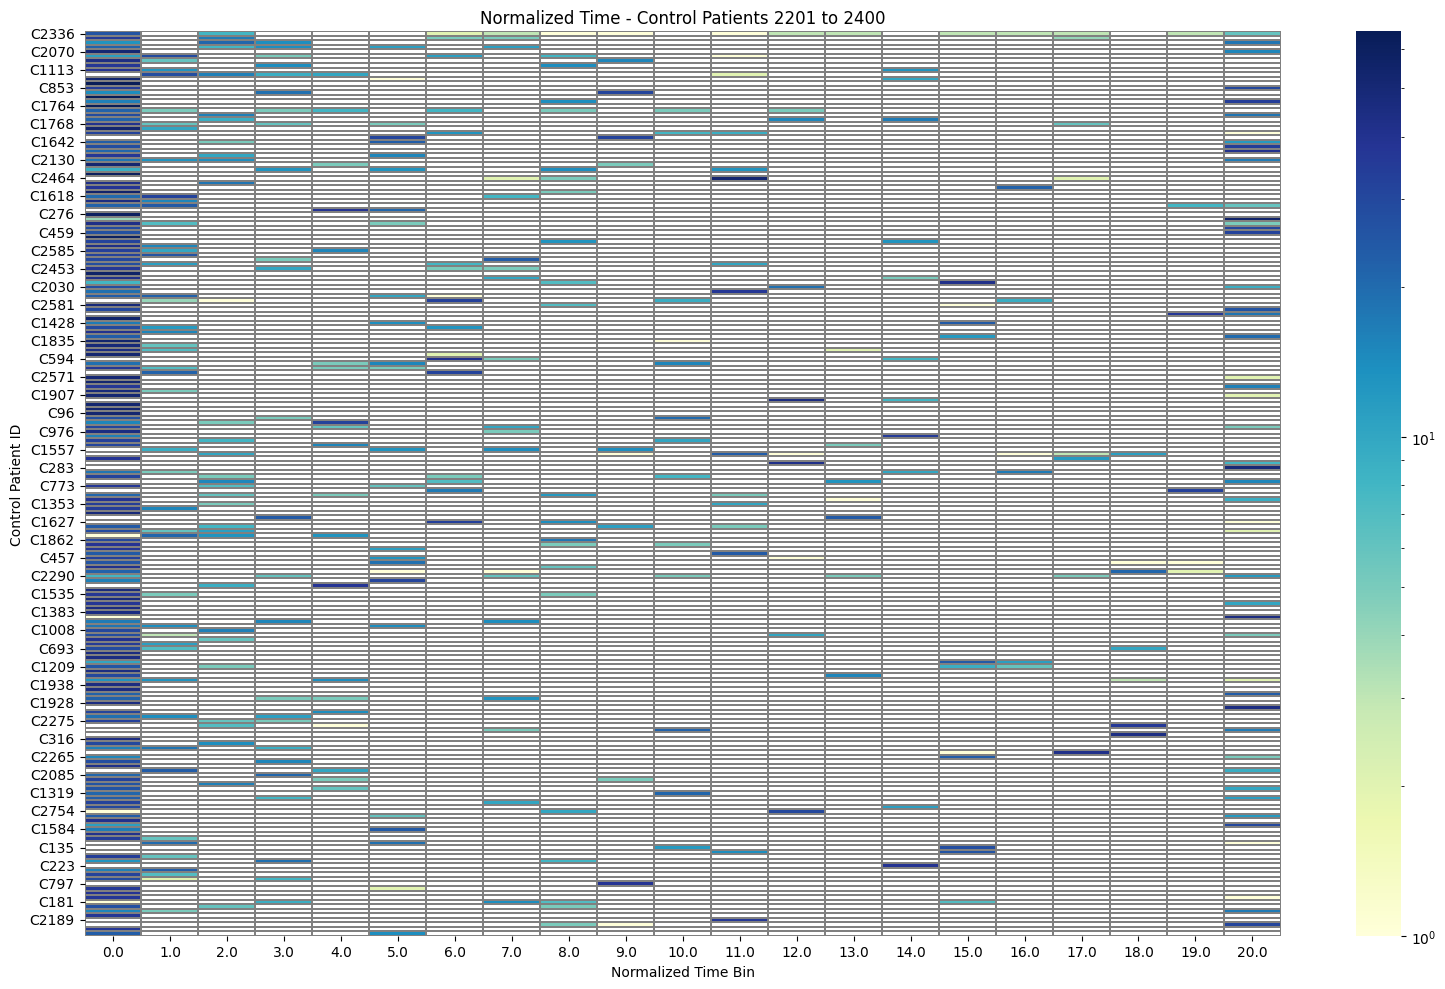

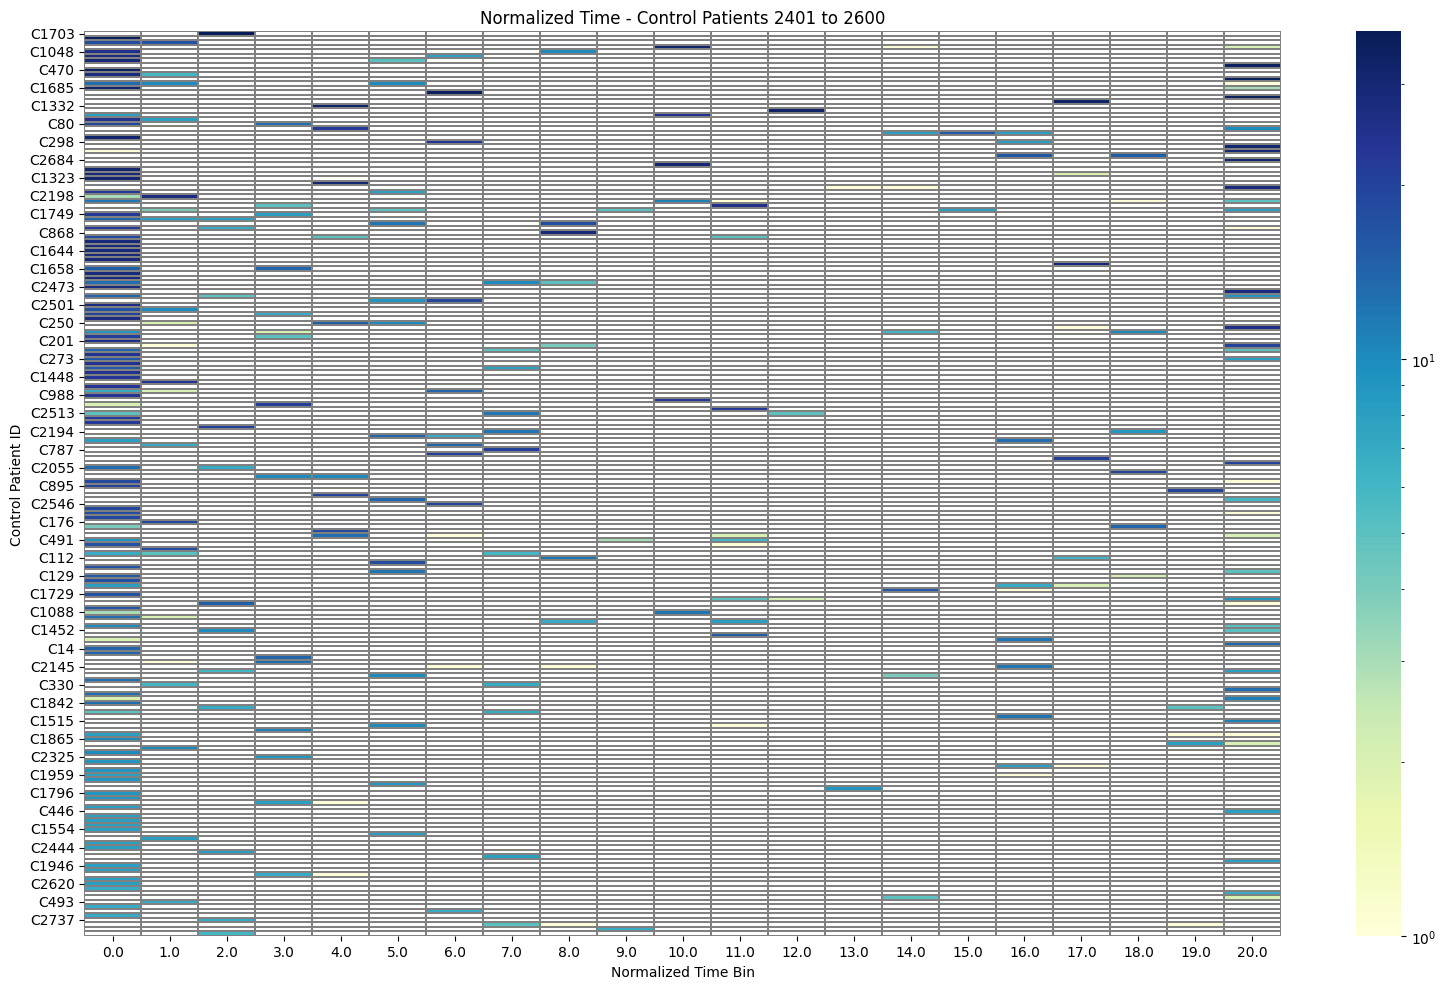

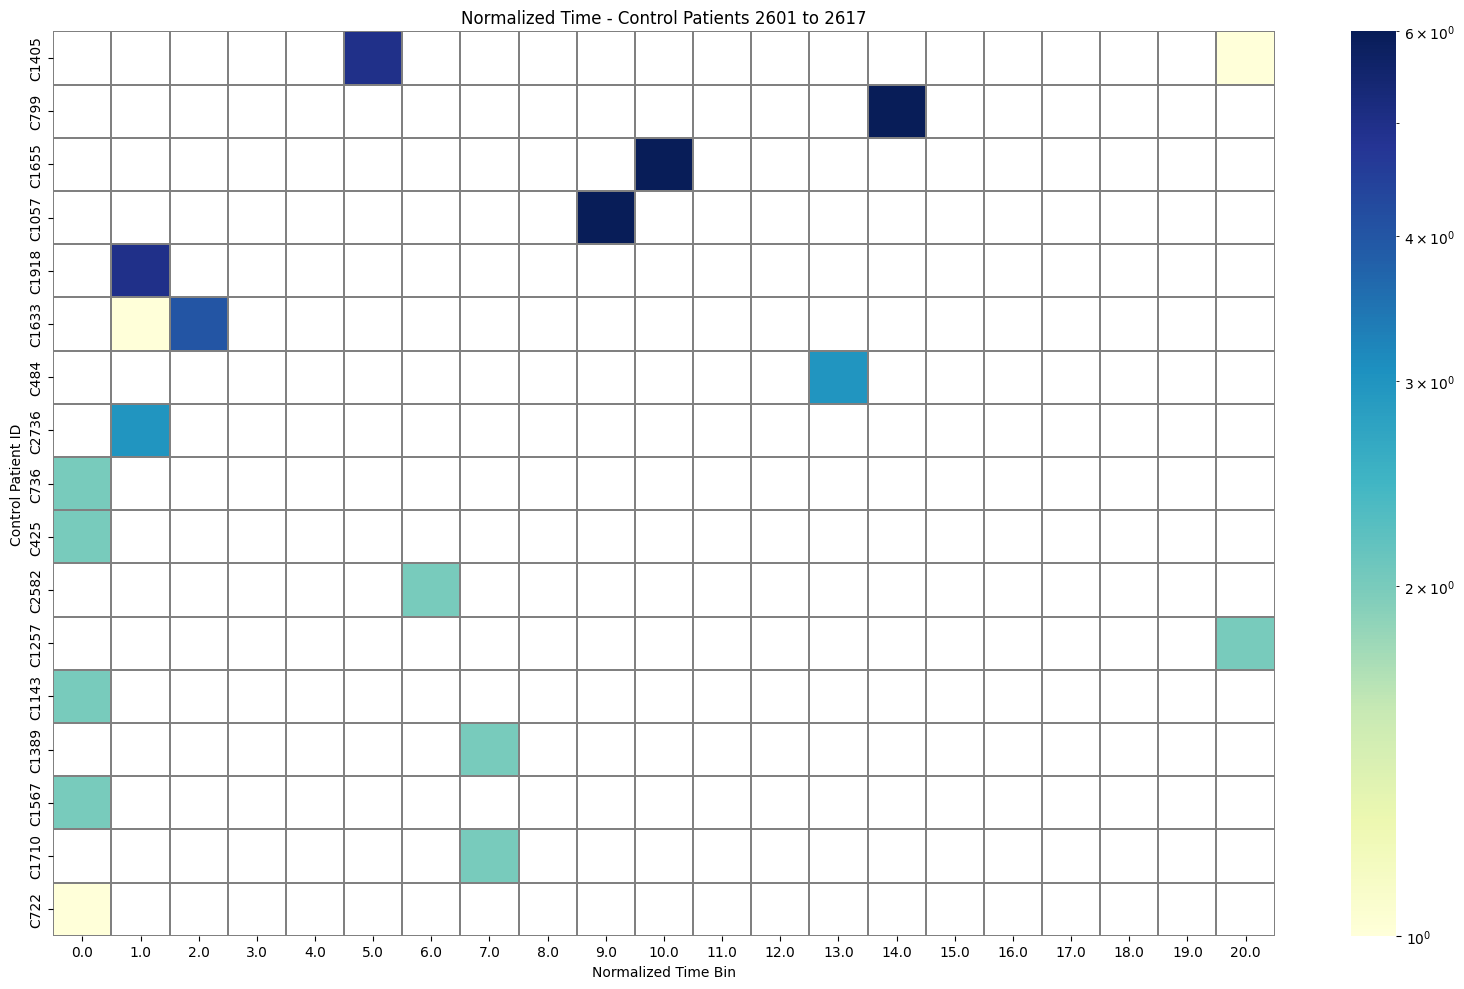

In [ ]:

# Plot VT heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(vt_relative, cmap="YlGnBu", linewidths=0.1, linecolor="gray", vmin=1, norm=mcolors.LogNorm())
plt.title("Normalized Time (0–1) - Measurements per VT Patient")
plt.xlabel("Normalized Time Bin")
plt.ylabel("VT Patient ID")
plt.tight_layout()
plt.show()

# Plot Controls in batches of 200
batch_size = 200
total_controls = control_relative.shape[0]
num_batches = (total_controls // batch_size) + 1

for i in range(num_batches):
    start = i * batch_size
    end = start + batch_size
    subset = control_relative.iloc[start:end]
    
    if subset.empty:
        continue

    plt.figure(figsize=(16, 10))
    sns.heatmap(subset, cmap="YlGnBu", linewidths=0.1, linecolor="gray", vmin=1, norm=mcolors.LogNorm())
    plt.title(f"Normalized Time - Control Patients {start + 1} to {min(end, total_controls)}")
    plt.xlabel("Normalized Time Bin")
    plt.ylabel("Control Patient ID")
    plt.tight_layout()
    plt.show()


In [ ]:
# Create masks for early and late measurements
has_early = data[data["Normalized Time"] <= 0.5].groupby("PatID").size()
has_late = data[data["Normalized Time"] > 0.5].groupby("PatID").size()

# patients with both early and late data
patients_with_both = has_early.index.intersection(has_late.index)

# Filter the data to include only these patients
filtered_data = data[data["PatID"].isin(patients_with_both)].copy()

print(f"Original patients: {data['PatID'].nunique()}")
print(f"Remaining after early/late check: {filtered_data['PatID'].nunique()}")


Original patients: 2732
Remaining after early/late check: 2211


In [ ]:
# Total number of rows in lab_data
total_rows = filtered_data.shape[0]


# Count VT and Control patients
vt_count = filtered_data[filtered_data["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = filtered_data[filtered_data["PatID"].str.startswith("C")]["PatID"].nunique()

print(f"Total rows in lab_data: {total_rows}")

print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = filtered_data["Oms_Code"].nunique()
print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 1280967
VT patients: 87
Control patients: 2124
Total unique tests (Oms_Code): 144


In [ ]:
# Set coverage threshold 
coverage_threshold = 0.70

# Total patients after step 1
total_patients = filtered_data["PatID"].nunique()

# Count for each test: in how many unique patients does it appear
test_coverage = filtered_data.groupby("Oms_Code")["PatID"].nunique()

# Keep only tests with coverage >= threshold
shared_tests = test_coverage[test_coverage >= (coverage_threshold * total_patients)].index

# Filter the data
final_data = filtered_data[filtered_data["Oms_Code"].isin(shared_tests)].copy()


print(f"Tests retained with ≥{int(coverage_threshold * 100)}% patient coverage: {len(shared_tests)}")
print(f"Patients remaining: {final_data['PatID'].nunique()}")
print(f"Final rows: {final_data.shape[0]}")



Tests retained with ≥70% patient coverage: 39
Patients remaining: 2210
Final rows: 903497


In [ ]:
# Total number of rows in lab_data
total_rows = final_data.shape[0]


# Count VT and Control patients
vt_count = final_data[final_data["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = final_data[final_data["PatID"].str.startswith("C")]["PatID"].nunique()
# Print results
print(f"Total rows in lab_data: {total_rows}")
#print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = final_data["Oms_Code"].nunique()
print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 903497
VT patients: 87
Control patients: 2123
Total unique tests (Oms_Code): 39


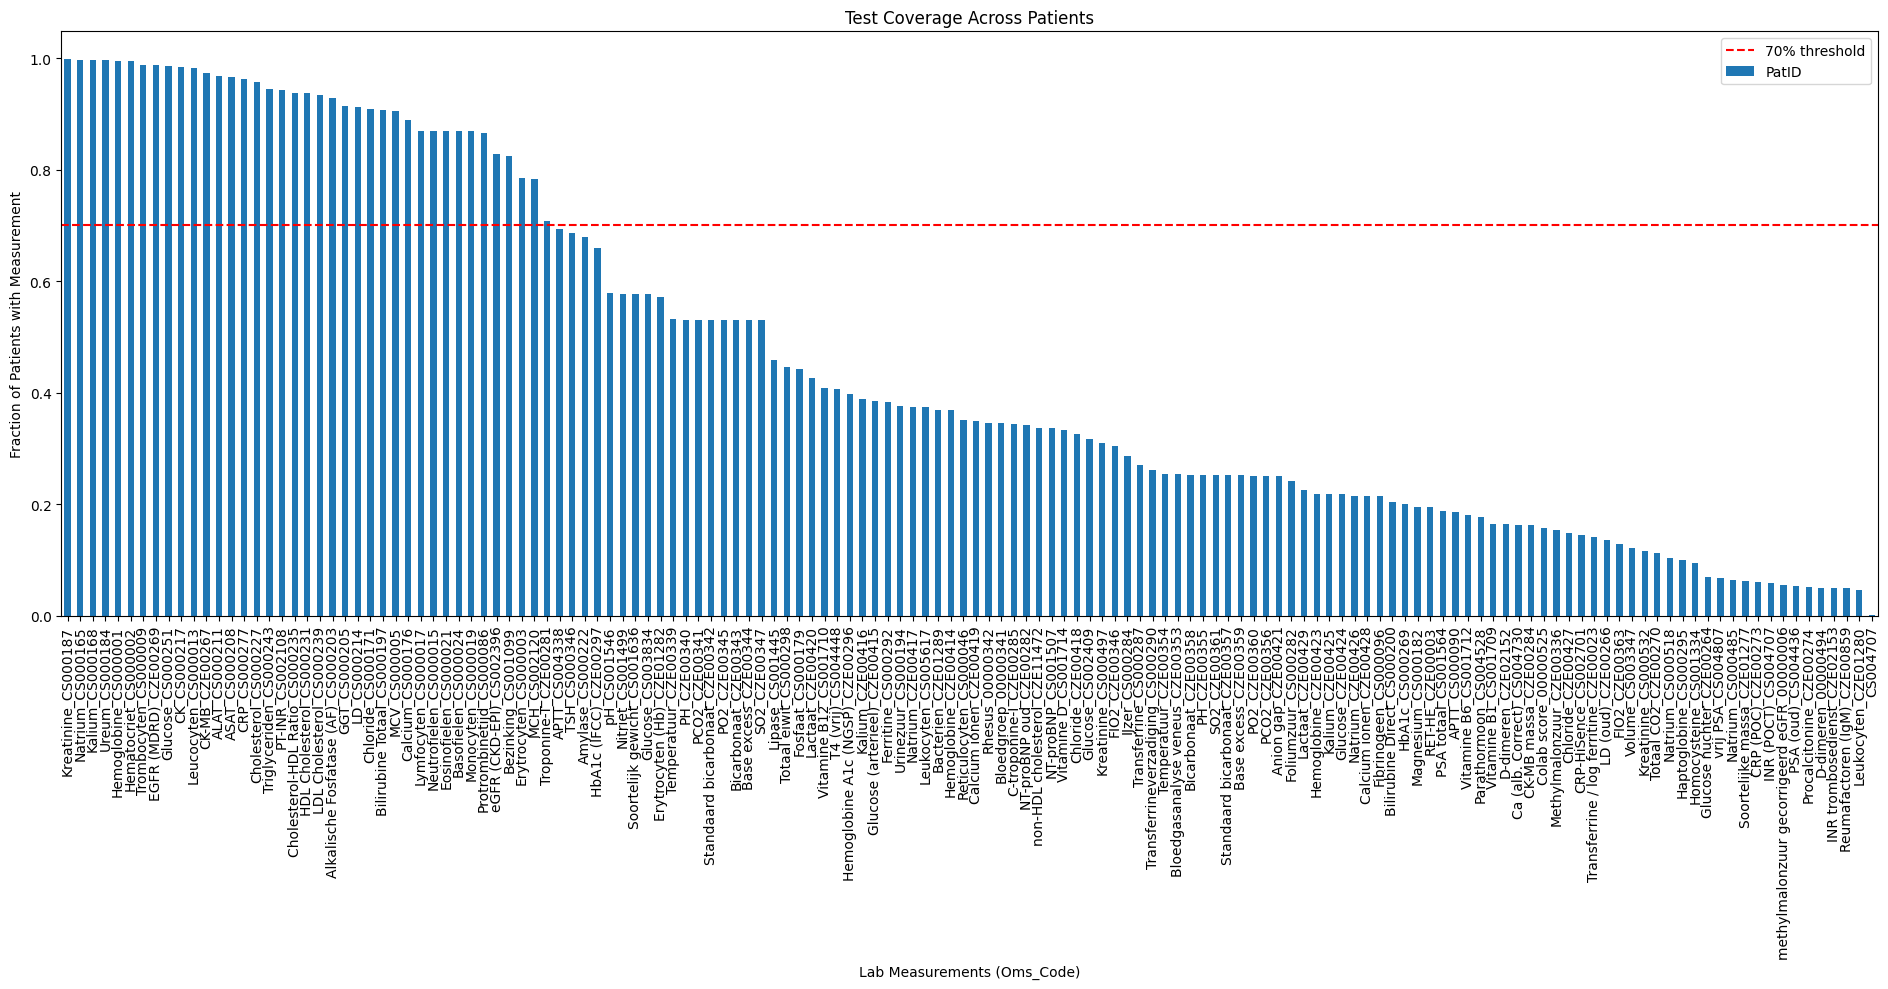

In [40]:
plt.figure(figsize=(19, 10))
(test_coverage / total_patients).sort_values(ascending=False).plot(kind="bar")
plt.axhline(coverage_threshold, color="red", linestyle="--", label=f"{int(coverage_threshold * 100)}% threshold")
plt.title("Test Coverage Across Patients")
plt.ylabel("Fraction of Patients with Measurement")
plt.xlabel("Lab Measurements (Oms_Code)")
plt.legend()
plt.tight_layout()
plt.savefig("test_coverage_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()


distinction for control and vt patients

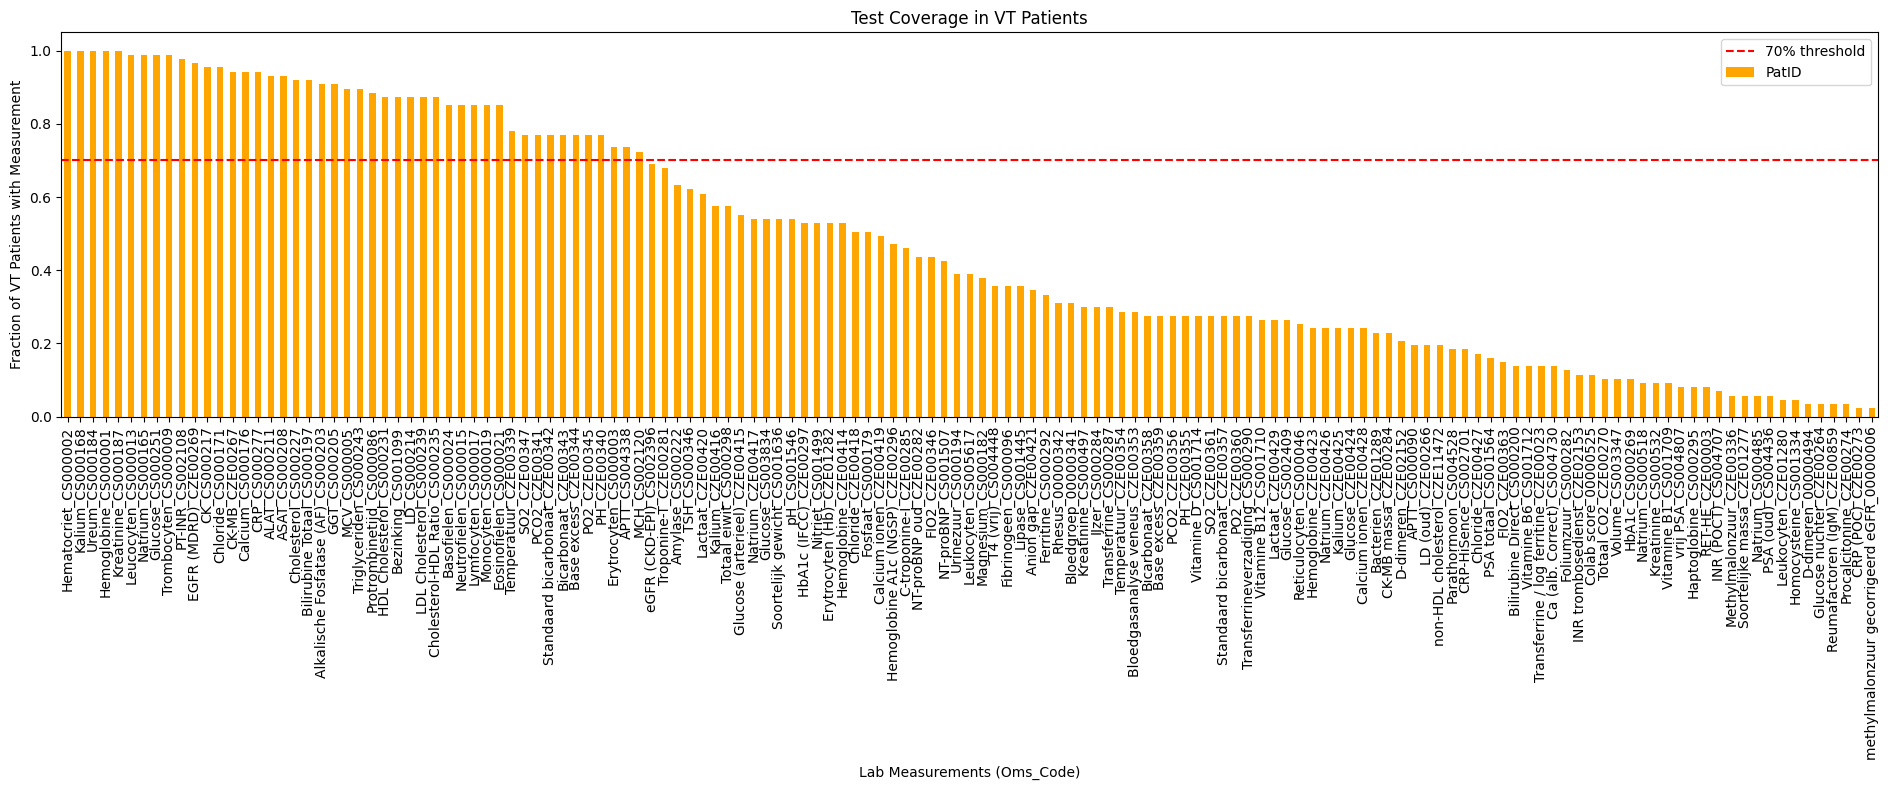

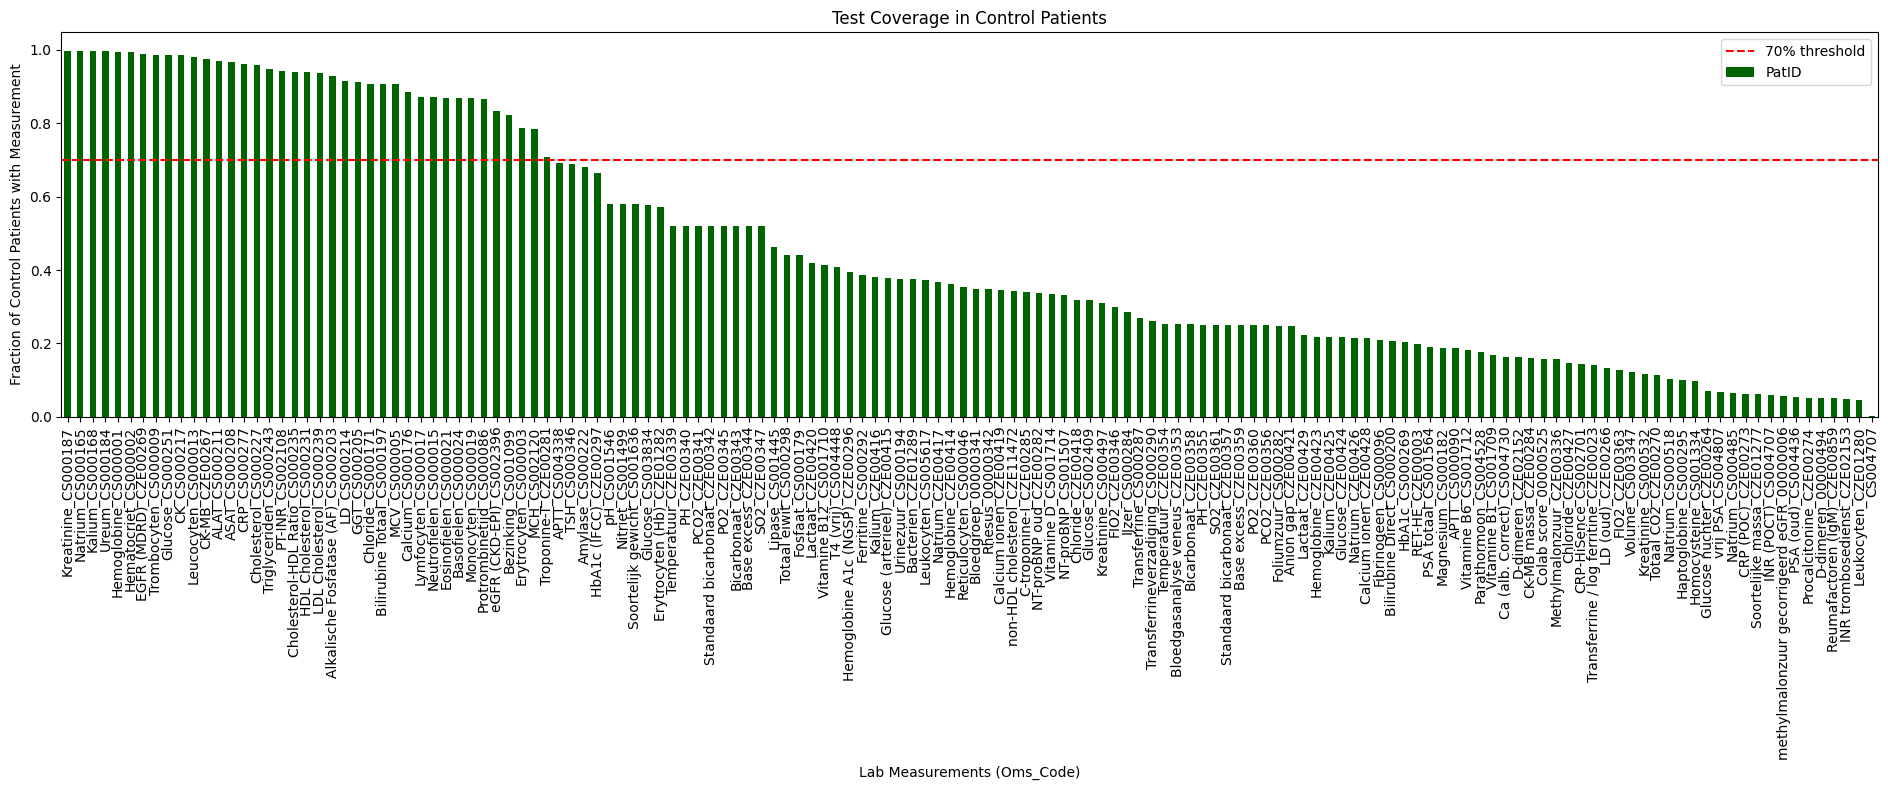

In [ ]:
patient_groups = data[["PatID", "Group"]].drop_duplicates().set_index("PatID")

# Merge into filtered_data 
if "Group" not in filtered_data.columns:
    filtered_data = filtered_data.merge(patient_groups, left_on="PatID", right_index=True, how="left")

# Split data into VT and Control groups
vt_data = filtered_data[filtered_data["Group"] == "VT"]
control_data = filtered_data[filtered_data["Group"] == "Control"]

# Total patients in each group
vt_total = vt_data["PatID"].nunique()
control_total = control_data["PatID"].nunique()

# Calculate test coverage 
vt_coverage = vt_data.groupby("Oms_Code")["PatID"].nunique() / vt_total
control_coverage = control_data.groupby("Oms_Code")["PatID"].nunique() / control_total

# VT group plot
plt.figure(figsize=(19, 8))
vt_coverage.sort_values(ascending=False).plot(kind="bar", color="orange") #steelblue
plt.axhline(coverage_threshold, color="red", linestyle="--", label=f"{int(coverage_threshold*100)}% threshold")
plt.title("Test Coverage in VT Patients")
plt.ylabel("Fraction of VT Patients with Measurement")
plt.xlabel("Lab Measurements (Oms_Code)")
plt.legend()
plt.tight_layout()
plt.savefig("test_coverage_plot_VT.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Control group plot
plt.figure(figsize=(19, 8))
control_coverage.sort_values(ascending=False).plot(kind="bar", color="darkgreen")
plt.axhline(coverage_threshold, color="red", linestyle="--", label=f"{int(coverage_threshold*100)}% threshold")
plt.title("Test Coverage in Control Patients")
plt.ylabel("Fraction of Control Patients with Measurement")
plt.xlabel("Lab Measurements (Oms_Code)")
plt.legend()
plt.tight_layout()
plt.savefig("test_coverage_plot_C.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
print("\n Final Summary ")
print(f"Patients remaining: {final_data['PatID'].nunique()}")
print(f"Tests remaining: {final_data['Oms_Code'].nunique()}")
print(f"Rows remaining: {final_data.shape[0]}")



--- Final Summary ---
Patients remaining: 2210
Tests remaining: 39
Rows remaining: 903497


In [ ]:
total_rows = final_data.shape[0]
unique_patients = final_data["PatID"].nunique()

# Count VT and Control patients
vt_count = final_data[final_data["PatID"].str.startswith("VT")]["PatID"].nunique()
control_count = final_data[final_data["PatID"].str.startswith("C")]["PatID"].nunique()

print(f"Total rows in lab_data: {total_rows}")
print(f"Total unique patients: {unique_patients}")
print(f"VT patients: {vt_count}")
print(f"Control patients: {control_count}")

# Count unique test types
unique_tests = final_data["Oms_Code"].nunique()


print(f"Total unique tests (Oms_Code): {unique_tests}")

Total rows in lab_data: 903497
Total unique patients: 2210
VT patients: 87
Control patients: 2123
Total unique tests (Oms_Code): 39
